# Create land surface dataset for CLM6
- Authors: Jiang Zhu (jiangzhu@ucar.edu) with help from Sophia Macarewich (macarew@ucar.edu)
- Objective: Generate land surface properties for the Last Glacial Maximum (LGM), including exposed continental shelves and ice sheets based on ICE-6G reconstructions.
- Workflow
  - Step 1: Fill some raw data with nearest neighbor, such as LAI, soil color, FMAX, etc. (These do not impact land units: vegetation/crop, lake, glacier, and urban).
  - Step 2: Remove lakes beneath LGM ice sheets.
  - Step 3: Modify PFTs for LGM, including shelf exposure and glacier regions.
  - Step 4: Create LGM glacier files.
  - Step 5: Run mksurfdat.
- Notes
  - The key is creating a set of LGM raw files for land surface properties and the associated namelist.  
  - Workflow differs from previous versions: raw files are modified directly before running mksurfdat.
  - We use "noanthro" mode of CTSM without anthropogenic influences.
  - Use large memory (I used a node on Derecho).
- Tools used
  - [mksurfdata_esmf](https://github.com/ESCOMP/CTSM/tree/master/tools/mksurfdata_esmf) - generates CLM-compatible land surface files.
  - [f90nml](https://github.com/marshallward/f90nml) – for reading/writing Fortran namelist files.
  - NCO (run with `subprocess`)
- References
  - [CTSM Tech Note](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/index.html)
  - [GitHub Discussion](https://github.com/ESCOMP/CTSM/discussions/1919)
  - [GitHub Issues](https://github.com/ESCOMP/CTSM/issues/578)

In [1]:
import subprocess
import datetime
import copy
import f90nml
import re
from pathlib import Path
import os

import numpy as np
import xarray as xr
import dask
import hvplot.xarray
import matplotlib.pyplot as plt

---
## Input
- The namelist file for the preindustrial case (using potential vegetation and without urban, etc.)
  - You can generate it yourself, e.g., `./gen_mksurfdata_namelist --res 'ne30np4.pg3' --start-year 1850 --end-year 1850 --potveg_flag --nocrop`
  - Or, copy it over from other places, such as /glade/campaign/cesm/development/palwg/scripts/setup/mksurfdata
- The LGM land fraction and glacier coverage from ICE-6G & GMTED2010
  - The "high resolution" land fraction file is an output when generating CAM7 topo file (with create_cam7_topo.ipynb)

In [2]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf'
os.makedirs(work_dir, exist_ok=True)

250924


In [3]:
file_lgm_landf = '/glade/campaign/cesm/development/palwg/raw_boundary_data/gmted2010/gmted2010_modis_bedmachine-rawdata-220518_i6g21ka_20250921.nc'

In [4]:
ice6g_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/ice-6g_c'
ice6g_pre_fname = 'I6_C.VM5a_1deg.0.nc'
ice6g_lgm_fname = 'I6_C.VM5a_1deg.21.nc'

### Select grid to create land surface dataset
- You can select one or more resolutions from the existing options or add new ones.  

In [5]:
# grids = ['ne30np4.pg3', 'ne16np4.pg3', '0.9x1.25', '1.9x2.5']
grids = ['ne30np4.pg3', 'ne16np4.pg3']

---
## Output
- `grid_configs` stores the configuration settings for generating surfdata at different resolutions.  
- `fsurdat_out` and `fsurdat_log` are the final outputs produced by `mksurfdata`.  

In [6]:
grid_configs = {}

In [7]:
for grid in grids:

    base_name = f"surfdata_{grid}_PtVeg_nourb_1850_16pfts"  # Don't change it.

    grid_configs[grid] = {
        "pre_nml": f"{work_dir}/{base_name}_c{today}.namelist",
        "lgm_nml": f"{work_dir}/{base_name}_21ka_c{today}.namelist",
        "fsurdat_out": f"{work_dir}/{base_name}_21ka_c{today}.nc",
        "fsurdat_log": f"{work_dir}/{base_name}_21ka_c{today}.log",
        "fsurdat_out_topostats": f"{work_dir}/{base_name}_21ka_topostats_c{today}.nc",
    }

# These are only used if you do the final step: Update the SLOPE and STDELEV variables in the surfdata
grid_configs['ne30np4.pg3']["fsurdat_pre"] = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/surfdata_ne30np4.pg3_hist_1850_78pfts_c240908.nc'
grid_configs['ne16np4.pg3']["fsurdat_pre"] = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/surfdata_ne16np4.pg3_hist_1850_78pfts_c240908.nc'

print("Grid configurations for LGM:")
for grid, cfg in grid_configs.items():
    print(f"{grid}:")
    for k, v in cfg.items():
        print(f"  {k:<16} -> {v}")

Grid configurations for LGM:
ne30np4.pg3:
  pre_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c250924.namelist
  lgm_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.namelist
  fsurdat_out      -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.nc
  fsurdat_log      -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.log
  fsurdat_out_topostats -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_topostats_c250924.nc
  fsurdat_pre      -> /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/surfdata_ne30np4.pg3_hist_1850_78pfts_c240908.nc
ne16np4.pg3:
  pre_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mks

---
## Executable and tools

In [8]:
mksurfdata_exe = "/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/tool_bld/mksurfdata"

### Createthe preindustrial namelist files
- Check to ensure the namelist files created match those in grid_configs
- Alternatively, you can copy it over from /glade/campaign/cesm/development/palwg/scripts/setup/mksurfdata

In [9]:

for grid, cfg in grid_configs.items():
    subprocess.run(
        [
            "/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/gen_mksurfdata_namelist",
            "--res", grid,
            "--start-year", "1850",
            "--end-year", "1850",
            "--potveg_flag",
            "--nocrop",
        ],
        check=True,
        cwd=work_dir,
    )

Successfully created input namelist file surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c250924.namelist
Successfully created input namelist file surfdata_ne16np4.pg3_PtVeg_nourb_1850_16pfts_c250924.namelist


### Function to fill nans with nearest neighbor
- Use n_points = 1 for better results (use 100 for quick test)

In [10]:
# def fill_na(da, lon_name, lat_name, n_points=100):  # Takes ~1.x minutes
def fill_na(da, lon_name, lat_name, n_points=1):  # Takes ~10+ minutes to nn fill raw files
    while da.isnull().any():
        da = da.ffill(dim=lon_name, limit=n_points)
        da = da.bfill(dim=lon_name, limit=n_points)
        da = da.ffill(dim=lat_name, limit=n_points)
        da = da.bfill(dim=lat_name, limit=n_points)
    return da

---
## Plot LGM land fraction and added glacier coverage derived from ICE-6G
- Pad variables in longitude direction for interpolation

In [11]:
def wrap_pad_latlon(ds, lon_name="lon", lat_name="lat"):
    """
    Wrap longitude and pad latitude if ds does not already
    cover [-180, 180] in lon and [-90, 90] in lat.
    """
    out = ds.copy()
    lon = out[lon_name]
    lat = out[lat_name]

    # ---- Wrap longitude separately ----
    if lon.min() > -180:
        west_pad = out.isel({lon_name: -1}).copy()
        west_pad = west_pad.assign_coords({lon_name: [lon[-1] - 360]})
        out = xr.concat([west_pad, out], dim=lon_name)

    if lon.max() < 180:
        east_pad = out.isel({lon_name: 0}).copy()
        east_pad = east_pad.assign_coords({lon_name: [lon[0] + 360]})
        out = xr.concat([out, east_pad], dim=lon_name)

    # ---- Pad latitude ----
    if lat.min() > -90:
        south_pad = out.isel({lat_name: 0}).expand_dims({lat_name: [-90]})
        out = xr.concat([south_pad, out], dim=lat_name)

    if lat.max() < 90:
        north_pad = out.isel({lat_name: -1}).expand_dims({lat_name: [90]})
        out = xr.concat([out, north_pad], dim=lat_name)

    return out


In [12]:
ds_lgm_landf = xr.open_dataset(file_lgm_landf)[['landfract']]

lgm_lndf = wrap_pad_latlon(ds_lgm_landf)['landfract']

lgm_lndf

<xarray.DataArray 'landfract' (lat: 21602, lon: 43202)> Size: 7GB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 173kB -90.0 -90.0 -89.99 -89.98 ... 89.99 90.0 90.0
  * lon      (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0

In [13]:
ice6g_pre_ds = xr.open_dataset(f"{ice6g_dir}/{ice6g_pre_fname}")
ice6g_lgm_ds = xr.open_dataset(f"{ice6g_dir}/{ice6g_lgm_fname}")

# Change the longitude to [-180, 180]
ice6g_pre_ds['lon'] = (ice6g_pre_ds.lon + 180) % 360 - 180
ice6g_lgm_ds['lon'] = (ice6g_lgm_ds.lon + 180) % 360 - 180
ice6g_pre_ds = ice6g_pre_ds.sortby(ice6g_pre_ds.lon)
ice6g_lgm_ds = ice6g_lgm_ds.sortby(ice6g_lgm_ds.lon)

# LGM changes

glc_lgm_i6g = wrap_pad_latlon(ice6g_lgm_ds)['sftgif']
glc_ano_i6g = wrap_pad_latlon(ice6g_lgm_ds - ice6g_pre_ds)['sftgif']
topo_ano_i6g = wrap_pad_latlon(ice6g_lgm_ds - ice6g_pre_ds)['orog']

print(topo_ano_i6g.max().values)
print(topo_ano_i6g.min().values)

3602.335693359375
-310.2841796875


In [14]:
glc_lgm_i6g

<xarray.DataArray 'sftgif' (lat: 182, lon: 362)> Size: 264kB
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5 90.0
  * lon      (lon) float64 3kB -180.5 -179.5 -178.5 -177.5 ... 178.5 179.5 180.5
Attributes:
    long_name:  Ice area fraction. Time=21 Ka
    units:      %
    time:        21.00 KBP

Text(0.5, 1.0, 'Added topography for LGM')

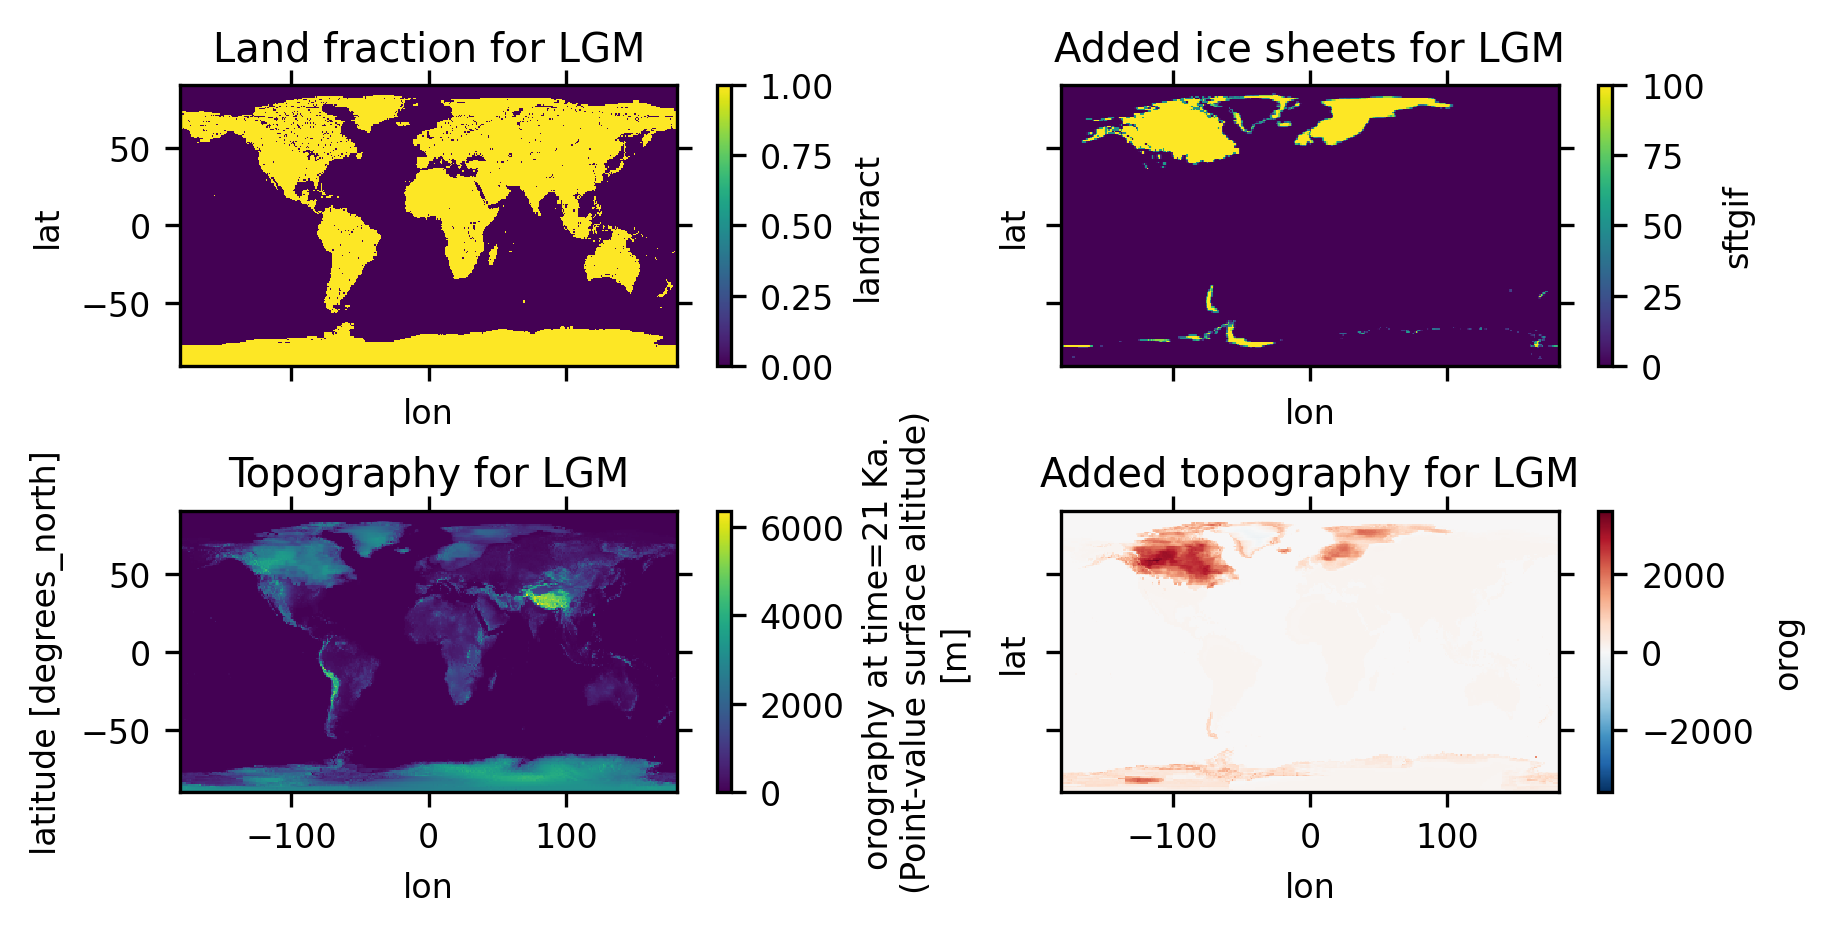

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(6, 3),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

lgm_lndf.thin(100).plot(ax=axes[0])
axes[0].set_title('Land fraction for LGM')

glc_ano_i6g.plot(ax=axes[1])
axes[1].set_title('Added ice sheets for LGM')

ice6g_lgm_ds.orog.plot(ax=axes[2])
axes[2].set_title('Topography for LGM')

topo_ano_i6g.plot(ax=axes[3])
axes[3].set_title('Added topography for LGM')

---
## Step 0: Explore the preindustrial namelist

### Raw files

In [16]:
cfg = next(iter(grid_configs.values()))

nml_dict = f90nml.read(cfg['pre_nml']).todict()
# nml_dict

In [17]:

raw_dict = {
    key: val
    for key, val in nml_dict['mksurfdata_input'].items()
    if not re.search("mesh", key)
}

for key in raw_dict:
    print(f"{key}: {nml_dict['mksurfdata_input'][key]}")

mksrf_flai: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM53RawData/globalctsm53histMKSRFDeg025_240709/mksrf_landuse_ctsm53_pftlai_CLIM.c240709.nc
mksrf_fsoicol: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM53RawData/globalctsm53histMKSRFDeg025_240709/mksrf_landuse_ctsm53_soilcolor_CLIM.c240709.nc
mksrf_fsoitex: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_mapunits_5x5min_WISE.c220330.nc
mksrf_fsoitex_lookup: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_lookup.10level.WISE.c220330.nc
mksrf_fmax: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc
mksrf_flakdep: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_LakePnDepth_3x3min_simyr2017_MODISgrid.cdf5.c200305.nc
mksrf_fwetlnd: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_lanwat.050425.nc
mksrf_fvocef: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_vocef_0.5x0.5_simyr2000.c1

- `ncdump` each file and check the CTSM Tech Note (e.g., [2.2.3.3](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#surface-data)) to figure out the strategy
- Files not modified
  - mksrf_fwetlnd: wetland is no long used since CLM4.5.
  - mksrf_flakdep: safe to use PI file (no new lakes at LGM).
  - mksrf_fpeat: peat is only used in fire parameterization, which is only relevant if carbon-nitrogen cycle is on. File is not interactive in CTSM?
  - mksrf_fgdp: not relevant in "NoAnthro" mode.
  - mksrf_furban: not relevant in "NoAnthro" mode.
  - mksrf_fhrvtyp: not relevant in "NoAnthro" mode.
  - mksrf_fabm: “peak month for agri fire”; not relevant in NoAnthro mode.
  - mksrf_furbtopo: only screens pcturb by elevation; not relevant in NoAnthro mode.
  - mksrf_vic: Variable Infiltration Capacity (VIC) is not used
- Special files for land units
  - mksrf_fglacier: we add the glacier coverage from ICE-6G.
  - mksrf_fglacierregion: we use a new file.
  - mksrf_fvegtyp: mask vegetation with ICE-6G ice; add vegetation on exposed shelves.
  - mksrf_fpctlak: mask lakes beneath ICE-6G ice.
- Other land surface properties
  - mksrf_flai: we cover LAI/SAI with ICE-6G ice sheets and add new LAI/SAI over exposed shelves.
  - mksrf_fsoicol: we add soil under ICE-6G ice sheets and over exposed shelves.
  - mksrf_fsoitex: we add soil under ICE-6G ice sheets and over exposed shelves.
  - mksrf_fmax: we add fractional saturated area under ICE-6G ice sheets and over exposed shelves.
  - mksrf_fvocef: add isoprene emissions over exposed shelves.
  - mksrf_fsoildepth: add soil depths over exposed shelves, leaving “depth to bedrock” variables as is.
- mksrf_ftopostats: `SLOPE` is used in [Surface Water Storage](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Hydrology/CLM50_Tech_Note_Hydrology.html#surface-water-storage) and `ELEVATION` is used in [Snow Covered Area Fraction](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Snow_Hydrology/CLM50_Tech_Note_Snow_Hydrology.html#snow-covered-area-fraction).
  - This file is hard to work with. We can update `SLOPE` and `STD_ELEV` once we have the LGM surfdata.
  - I think it is also fine to simply using the preindustrial files.
- ***NOTE: mksrf_fsoitex misses lat and lon info (LATIXY and LONGXY are all zeros)***
  - I will use lat and lon from mksrf_fsoildepth instead

### Set up lgm namelists

In [18]:
for grid, cfg in grid_configs.items():

    nml_dict = f90nml.read(cfg['pre_nml']).todict()
    lgm_nml_dict = copy.deepcopy(nml_dict)

    lgm_nml_dict['mksurfdata_input']['fsurdat'] = cfg['fsurdat_out']
    lgm_nml_dict['mksurfdata_input']['fsurlog'] = cfg['fsurdat_log']
    cfg['lgm_nml_dict'] = lgm_nml_dict

grid_configs

{'ne30np4.pg3': {'pre_nml': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c250924.namelist',
  'lgm_nml': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.namelist',
  'fsurdat_out': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.nc',
  'fsurdat_log': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.log',
  'fsurdat_out_topostats': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_topostats_c250924.nc',
  'fsurdat_pre': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/surfdata_ne30np4.pg3_hist_1850_78pfts_c240908.nc',
  'lgm_nml_dict': OrderedDict([('mksurfdata_input',
                OrderedDict([('mksrf_fgrid_mesh',
                     

---
## Step 1: Fill the following raw data with nearest neighbor
- The goal is to create land surface properties such as soil color for new land grid points
- `LANDMASK` in these LGM raw files need to be updated as well!

In [19]:
nnfill_dict = {
    'mksrf_flai': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_flai'],
        'vnames': ['MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP', 'MONTHLY_LAI', 'MONTHLY_SAI'],
        'lat_var': 'LAT',
        'lon_var': 'LON',
        'lat_dim': 'lat',
        'lon_dim': 'lon',
    },
    'mksrf_fsoicol': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoicol'],
        'vnames': ['SOIL_COLOR'],
        'lat_var': 'LAT',
        'lon_var': 'LON',
        'lat_dim': 'lat',
        'lon_dim': 'lon',
    },
    'mksrf_fmax': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fmax'],
        'vnames': ['FMAX'],
        'lat_var': 'lat',
        'lon_var': 'lon',
        'lat_dim': 'lat',
        'lon_dim': 'lon',
    },
    'mksrf_fvocef': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fvocef'],
        'vnames': ['ef_btr', 'ef_crp', 'ef_fdt', 'ef_fet', 'ef_grs', 'ef_shr'],
        'lat_var': 'lat',
        'lon_var': 'lon',
        'lat_dim': 'lat',
        'lon_dim': 'lon',
    },
    'mksrf_fsoildepth': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoildepth'],
        'vnames': ['Avg_Depth_Median', 'Avg_Depth_Mean'],
        'lat_var': 'LATIXY',
        'lon_var': 'LONGXY',
        'lat_dim': 'lat',
        'lon_dim': 'lon',
    },
    'mksrf_fsoitex': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoitex'],
        'vnames': ['MU'],
        'lat_var': 'LATIXY',
        'lon_var': 'LONGXY',
        'lat_dim': 'lsmlat',
        'lon_dim': 'lsmlon',
        'note': 'Use lat_soil/lon_soil arrays for interpolation',
    },
}

nnfill_dict


{'mksrf_flai': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM53RawData/globalctsm53histMKSRFDeg025_240709/mksrf_landuse_ctsm53_pftlai_CLIM.c240709.nc',
  'vnames': ['MONTHLY_HEIGHT_BOT',
   'MONTHLY_HEIGHT_TOP',
   'MONTHLY_LAI',
   'MONTHLY_SAI'],
  'lat_var': 'LAT',
  'lon_var': 'LON',
  'lat_dim': 'lat',
  'lon_dim': 'lon'},
 'mksrf_fsoicol': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM53RawData/globalctsm53histMKSRFDeg025_240709/mksrf_landuse_ctsm53_soilcolor_CLIM.c240709.nc',
  'vnames': ['SOIL_COLOR'],
  'lat_var': 'LAT',
  'lon_var': 'LON',
  'lat_dim': 'lat',
  'lon_dim': 'lon'},
 'mksrf_fmax': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc',
  'vnames': ['FMAX'],
  'lat_var': 'lat',
  'lon_var': 'lon',
  'lat_dim': 'lat',
  'lon_dim': 'lon'},
 'mksrf_fvocef': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_vocef_0.5x0.5_simyr2000.c1

- The following cell is needed because mksrf_fsoitex misses lat and lon info

In [20]:
ds_soil = xr.open_dataset(nnfill_dict['mksrf_fsoildepth']['raw_file'])
lat_soil = ds_soil.LATIXY
lon_soil = ds_soil.LONGXY

- This cell seems to be the slowest and you could chang it to `raw` to test the other parts of the notebook

In [21]:
%%time

# for key in ['mksrf_fsoitex']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoicol']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoildepth']:
#     case = nnfill_dict[key]

for key, case in nnfill_dict.items():

    # Figure out the input and output file names
    raw_file = case['raw_file']

    fname = Path(Path(raw_file).name)
    lgm_raw_file = f"{work_dir}/{fname.stem}_21ka_nnfilled{fname.suffix}"

    print(f"{key}: {case['vnames']}")
    print(f"Raw input: {raw_file}")
    print(f"Output: {lgm_raw_file}\n")

    ds = xr.open_dataset(raw_file)

    # Mask each variable first and then fill nans with nearest neighbor
    for vname in case['vnames']:

        # Soiltex file does not have a land mask
        if vname == 'MU':
            ds['LANDMASK'] = xr.where(ds.MU > 0, 1, 0)

        dims_order = ds[vname].dims
        var_masked = xr.where(ds.LANDMASK > 0, ds[vname], np.nan).transpose(*dims_order)

        filled = fill_na(var_masked, case['lon_dim'], case['lat_dim'])
        if vname == "MU":
            filled = filled.astype("int32")
            filled.encoding["_FillValue"] = -9999
        ds[vname] = filled

    lat = ds[case['lat_var']]
    lon = ds[case['lon_var']]
    if key == 'mksrf_fsoitex':
        lat = lat_soil
        lon = lon_soil

    lgm_lndf_interp = lgm_lndf.interp(lat=lat, lon=lon, method='linear')

    ds.LANDMASK.data = xr.where(
        (ds.LANDMASK < 1) & (lgm_lndf_interp.values > 0.5), 1, ds.LANDMASK)

    case['lgm_raw_file'] = lgm_raw_file

    ## Loop over grids and update the raw file in the namelist
    for grid, cfg in grid_configs.items():
        cfg['lgm_nml_dict']['mksurfdata_input'][key] = lgm_raw_file
    
    ds.to_netcdf(lgm_raw_file)
    subprocess.run(['ncks', "-hO5", lgm_raw_file, lgm_raw_file])

mksrf_flai: ['MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP', 'MONTHLY_LAI', 'MONTHLY_SAI']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM53RawData/globalctsm53histMKSRFDeg025_240709/mksrf_landuse_ctsm53_pftlai_CLIM.c240709.nc
Output: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_pftlai_CLIM.c240709_21ka_nnfilled.nc

mksrf_fsoicol: ['SOIL_COLOR']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM53RawData/globalctsm53histMKSRFDeg025_240709/mksrf_landuse_ctsm53_soilcolor_CLIM.c240709.nc
Output: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_soilcolor_CLIM.c240709_21ka_nnfilled.nc

mksrf_fmax: ['FMAX']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc
Output: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_fmax_0.125x0.125_c200220_21ka_nnfilled.nc

mksrf_fvocef: ['ef_btr', 'ef_crp', 'ef_fdt', 'ef_fet', 'ef_grs',

### Make plots to check results
- For simplicity, I compute and plot 2D fields (mean over non-lat and non-lon dimensions)
- Examine the "new land grid points" such as the Sunda Shelf in the Warm Pool. Do you see meaningful values?

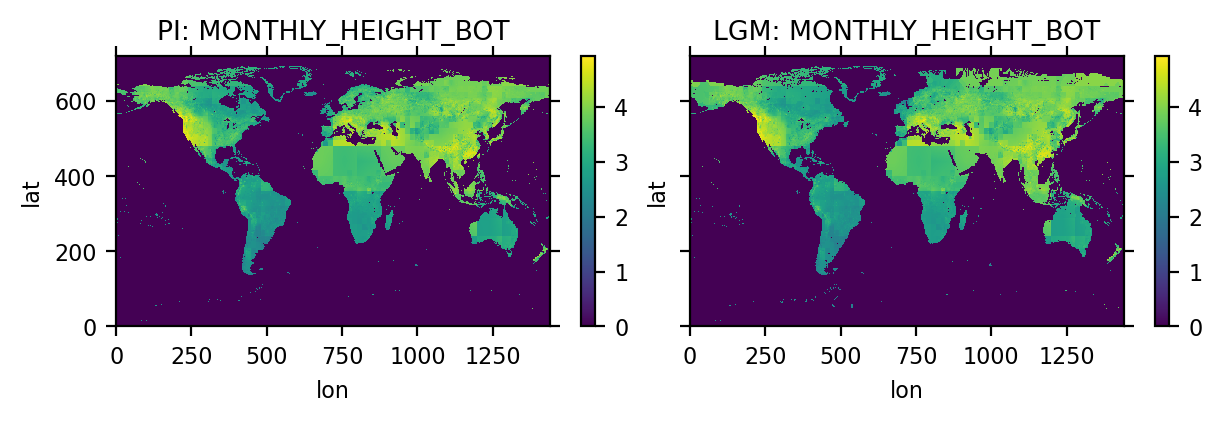

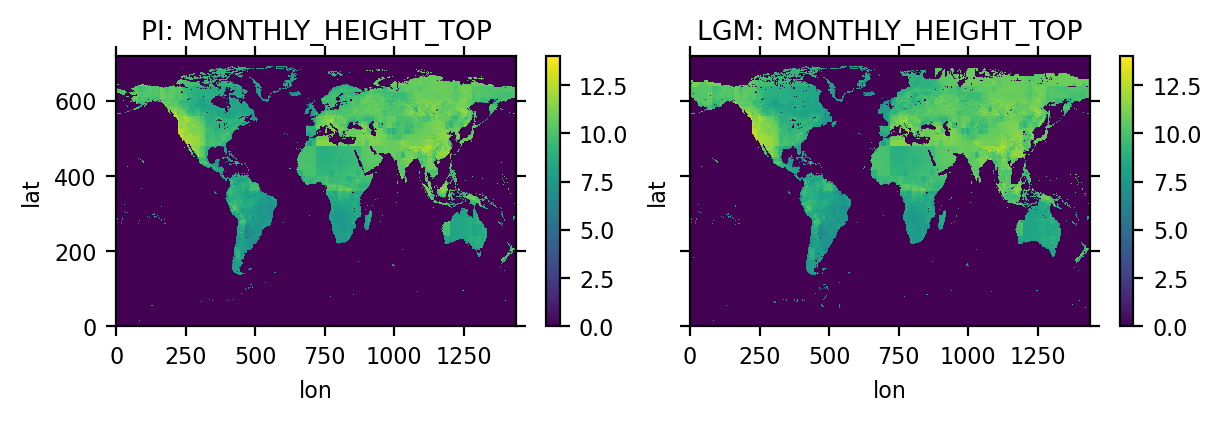

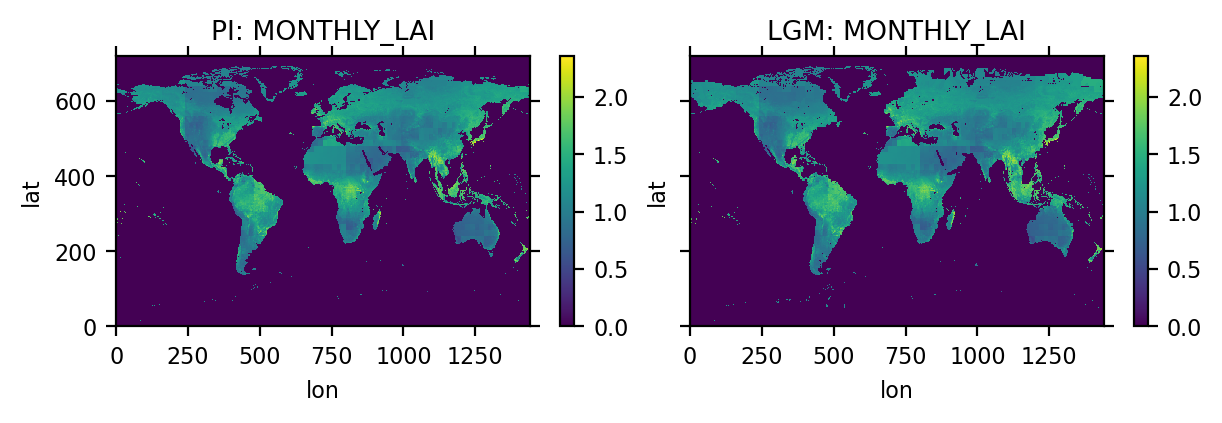

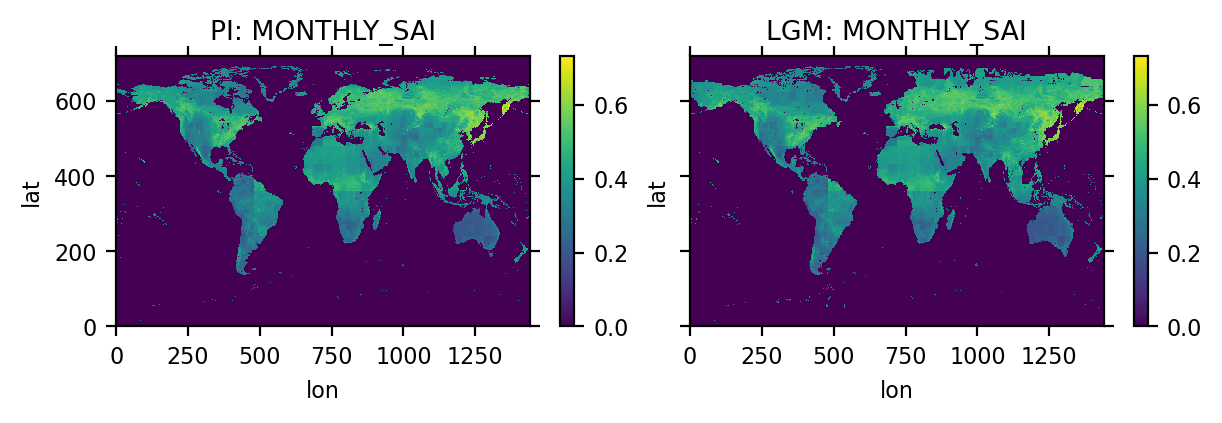

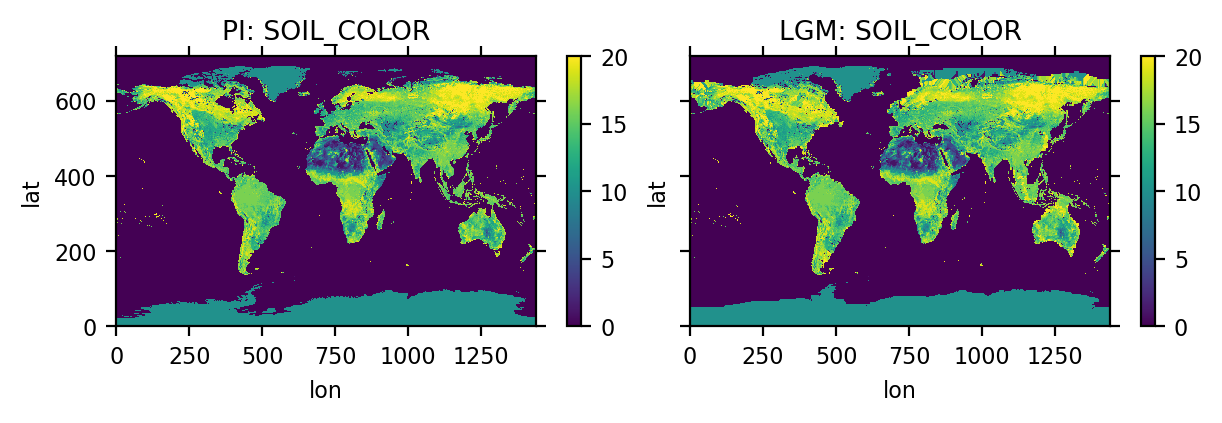

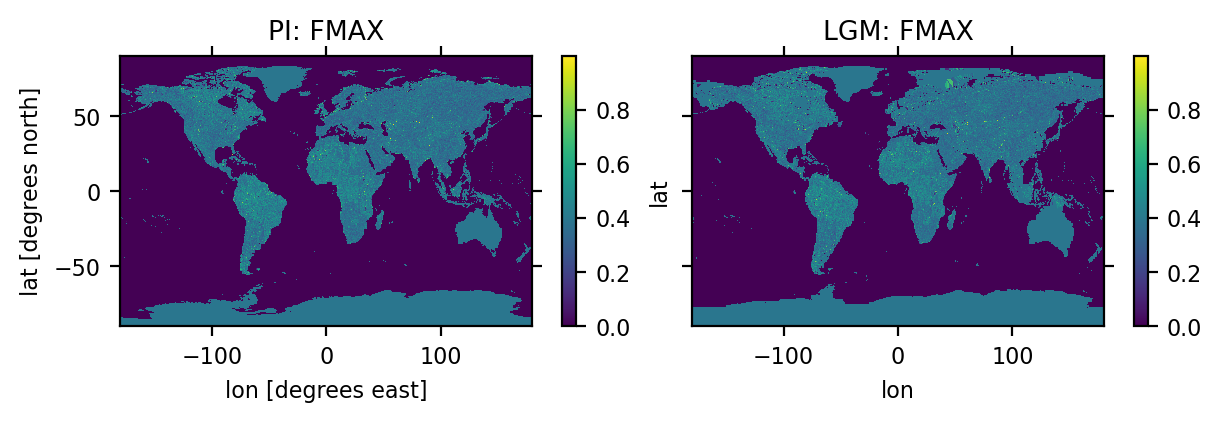

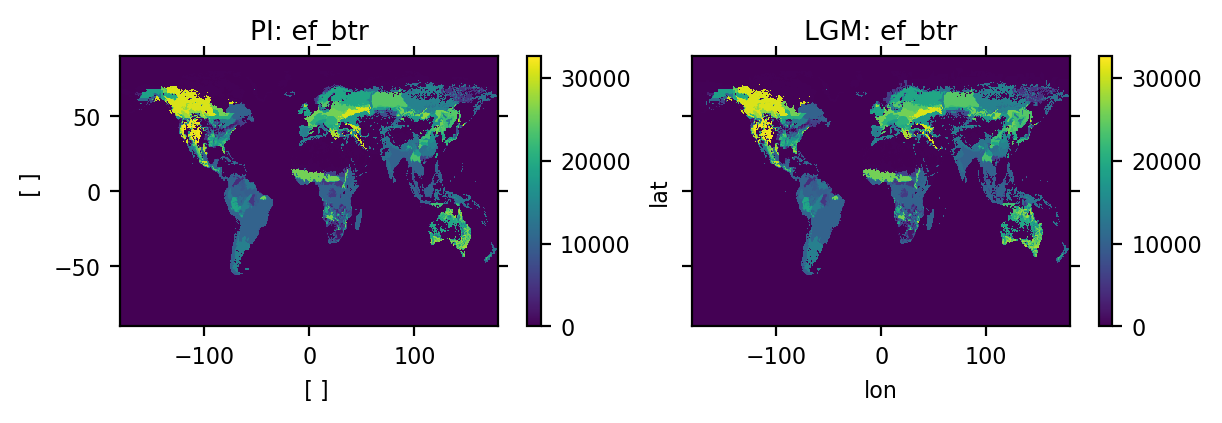

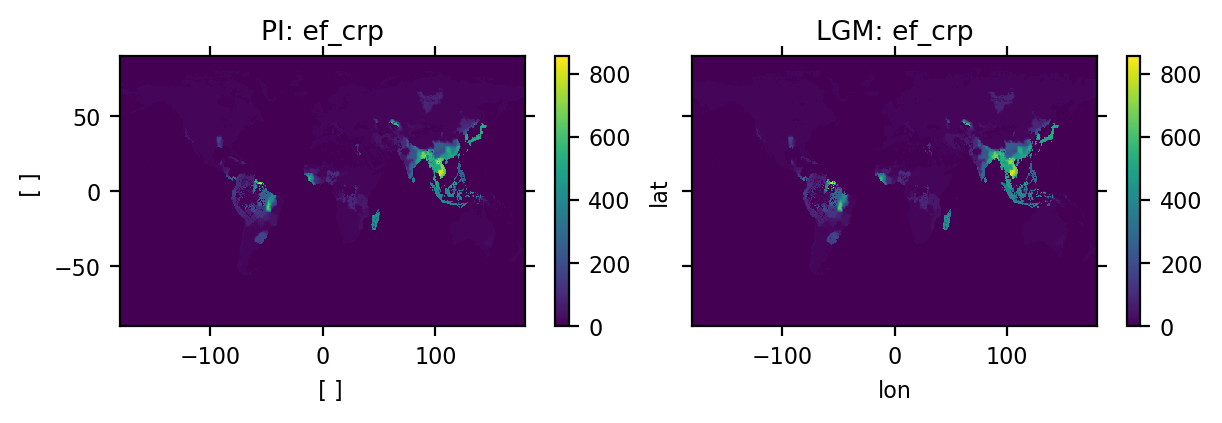

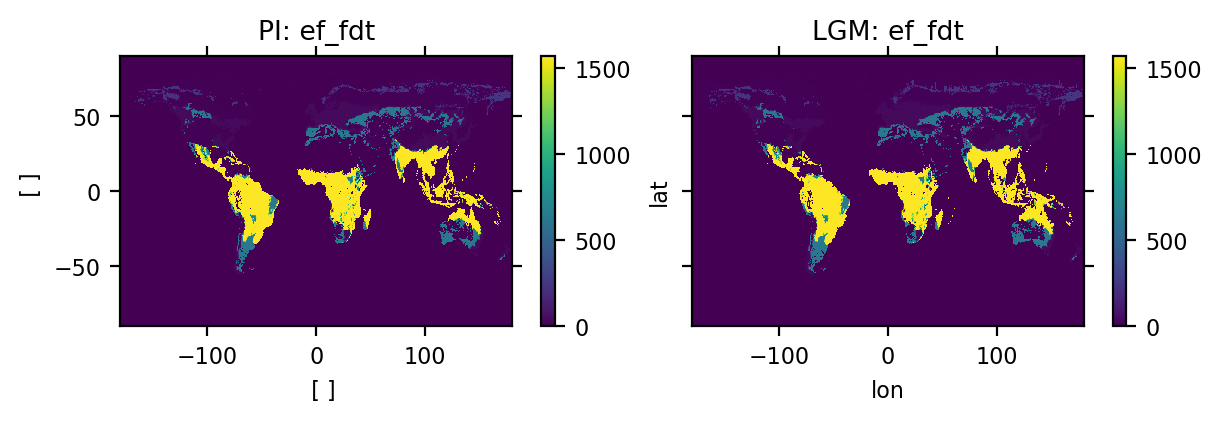

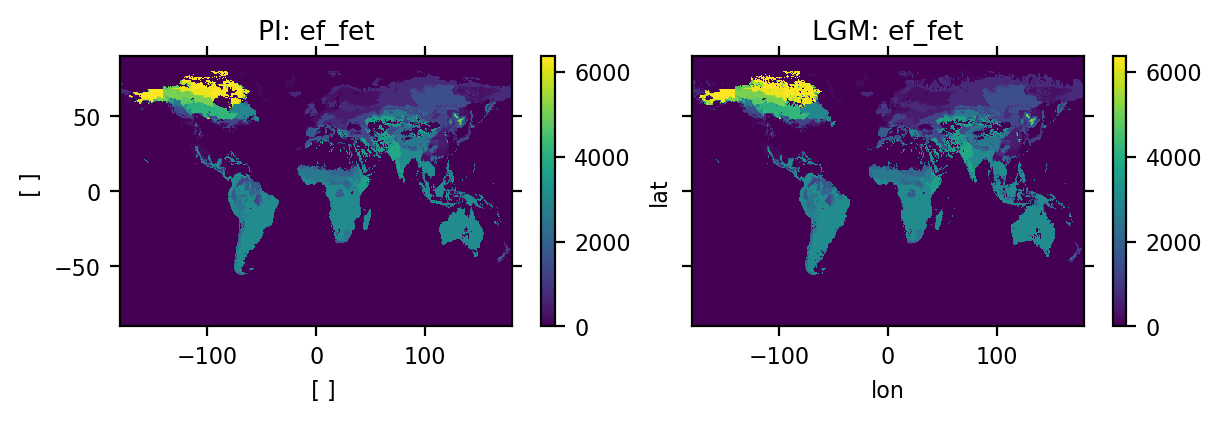

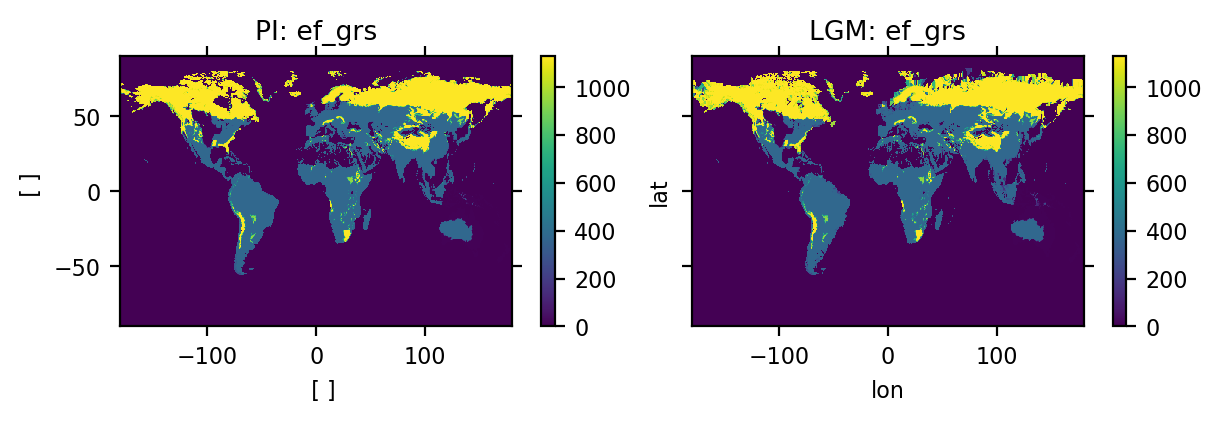

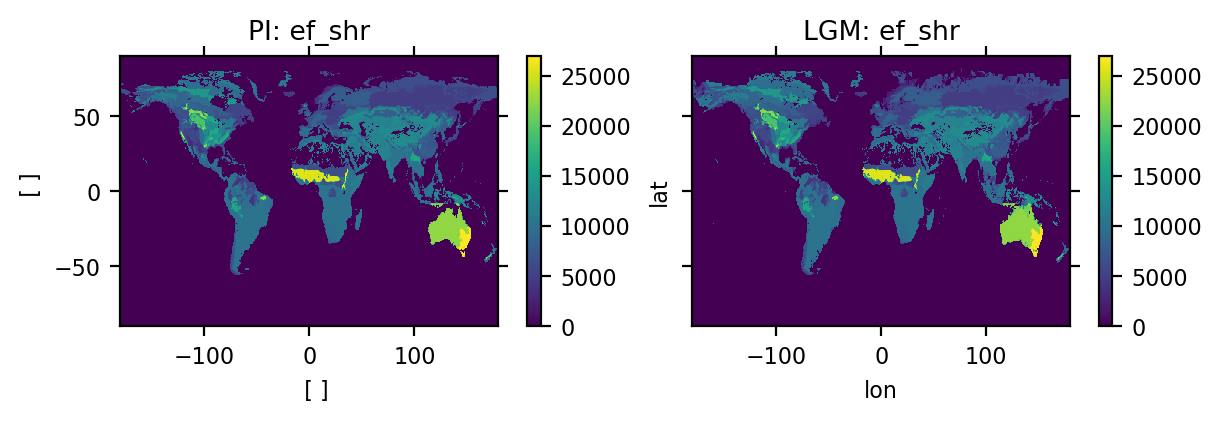

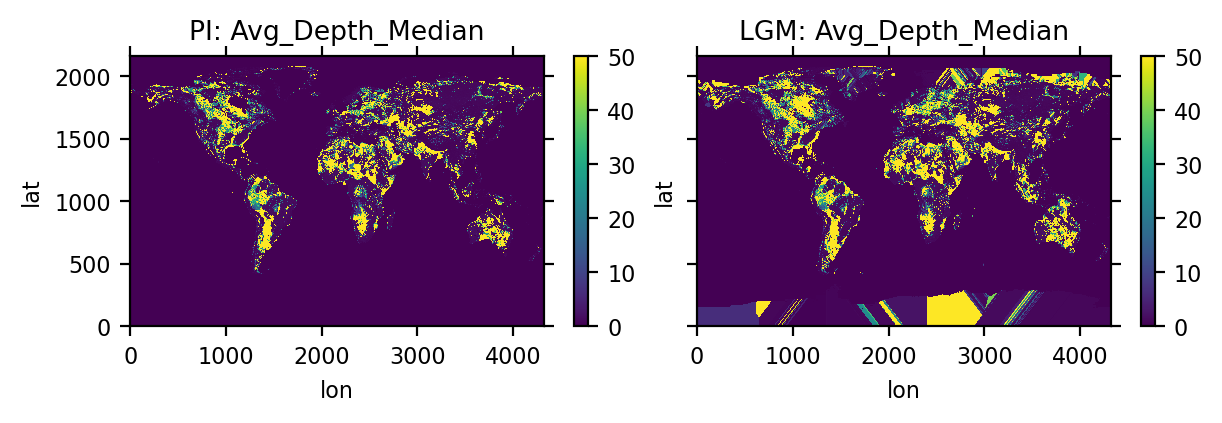

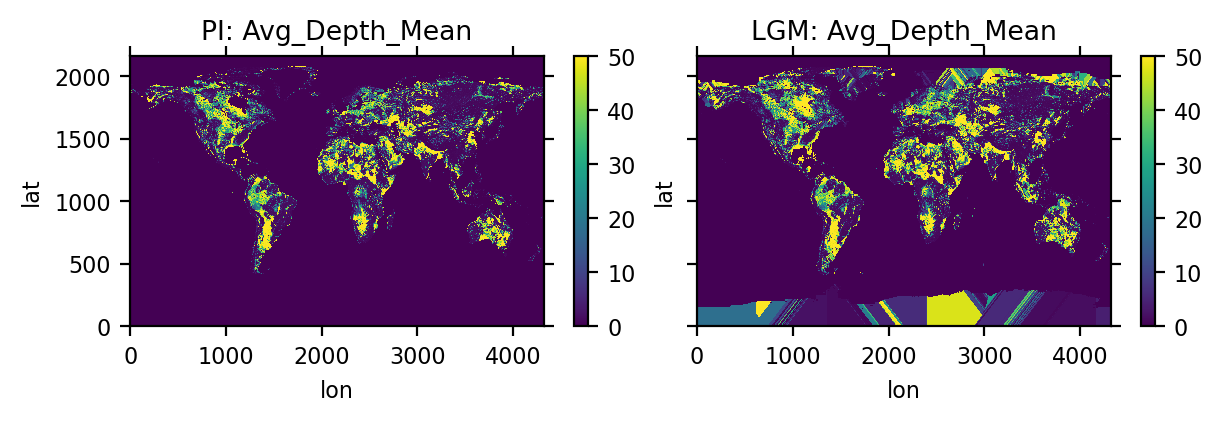

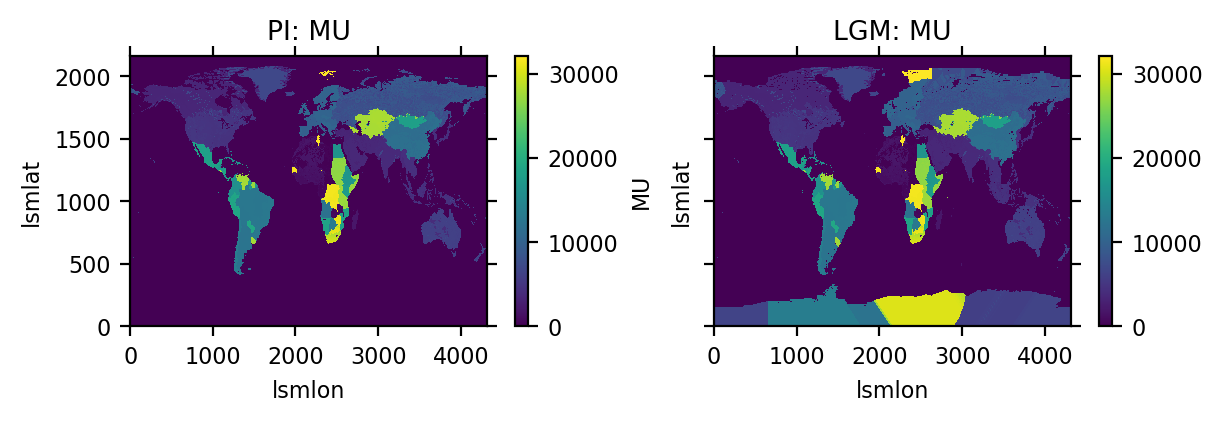

In [22]:
for key, case in nnfill_dict.items():

    ds = xr.open_dataset(case['raw_file'])
    ds_lgm = xr.open_dataset(case['lgm_raw_file'])

    for vname in case['vnames']:
        fig, axes = plt.subplots(
            1, 2, figsize=(6, 2), dpi=200, sharex=True, sharey=True,
            constrained_layout=True)

        # Soiltex file does not have a land mask
        if vname == 'MU':
            lmask = xr.where(ds.MU > 0, 1, 0)
        else:
            lmask = ds.LANDMASK

        lmask_lgm = ds_lgm.LANDMASK

        var = (ds[vname] * lmask).sortby(case['lon_dim'])
        var.mean(
            dim=[dim for dim in ds.dims if dim not in [
                case['lon_dim'], case['lat_dim']]]).plot(ax=axes[0])
        axes[0].set_title(f"PI: {vname}")

        var_lgm = (ds_lgm[vname] * lmask_lgm).sortby(case['lon_dim'])
        var_lgm.mean(
            dim=[dim for dim in ds.dims if dim not in [
                case['lon_dim'], case['lat_dim']]]).plot(ax=axes[1])
        axes[1].set_title(f"LGM: {vname}")

---
## Step 2: Remove lakes underneath the LGM ice sheets
- `LANDMASK` in the lake file is not used by mksurfdata_esmf

In [23]:
pctlak_file = nml_dict['mksurfdata_input']['mksrf_fpctlak']
ds_pctlak = xr.open_dataset(pctlak_file)

fname = Path(Path(pctlak_file).name)
lgm_pctlak_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"
print(lgm_pctlak_file)

ds_pctlak

/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksurf_lake_0.05x0.05_hist_clm5_hydrolakes_1850.cdf5.c20220325_21ka.nc


<xarray.Dataset> Size: 830MB
Dimensions:   (lat: 3600, lon: 7200)
Coordinates:
  * lat       (lat) float64 29kB -89.97 -89.92 -89.88 ... 89.87 89.92 89.97
  * lon       (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    PCT_LAKE  (lat, lon) float64 207MB ...
    LANDMASK  (lat, lon) float64 207MB ...
    LATIXY    (lat, lon) float64 207MB ...
    LONGXY    (lat, lon) float64 207MB ...
Attributes:
    source:         HydroLAKES polygons dataset v1.0 June 2019
    title:          Percent Lake calculated from the Hydrolakes dataset mappe...
    references:     Messager, M.L., Lehner, B., Grill, G., Nedeva, I., Schmit...
    url:            https://www.hydrosheds.org/pages/hydrolakes
    creation_date:  Thu Mar  5 13:41:39 2020

### Regrid the LGM added glacier coverage to the grid of lake file

In [24]:
glc_ano_i6g_int = glc_ano_i6g.interp(
    lat=ds_pctlak.lat, lon=ds_pctlak.lon, method='linear')
glc_ano_i6g_int

<xarray.DataArray 'sftgif' (lat: 3600, lon: 7200)> Size: 207MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 29kB -89.97 -89.92 -89.88 ... 89.87 89.92 89.97
  * lon      (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

### Remove lakes underneath ice sheets, save output and update the LGM namelist

In [25]:
ds_pctlak_lgm = ds_pctlak.copy(deep=True)

ds_pctlak_lgm.PCT_LAKE.data = xr.where(
    glc_ano_i6g_int > 50, 0, ds_pctlak.PCT_LAKE)

ds_pctlak_lgm.to_netcdf(lgm_pctlak_file)
subprocess.run(['ncks', "-hO5", lgm_pctlak_file, lgm_pctlak_file])

for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fpctlak'] = lgm_pctlak_file
    print(cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fpctlak'])

/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksurf_lake_0.05x0.05_hist_clm5_hydrolakes_1850.cdf5.c20220325_21ka.nc
/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksurf_lake_0.05x0.05_hist_clm5_hydrolakes_1850.cdf5.c20220325_21ka.nc


### Make plot to check results

Text(0.5, 1.0, 'LGM Changes')

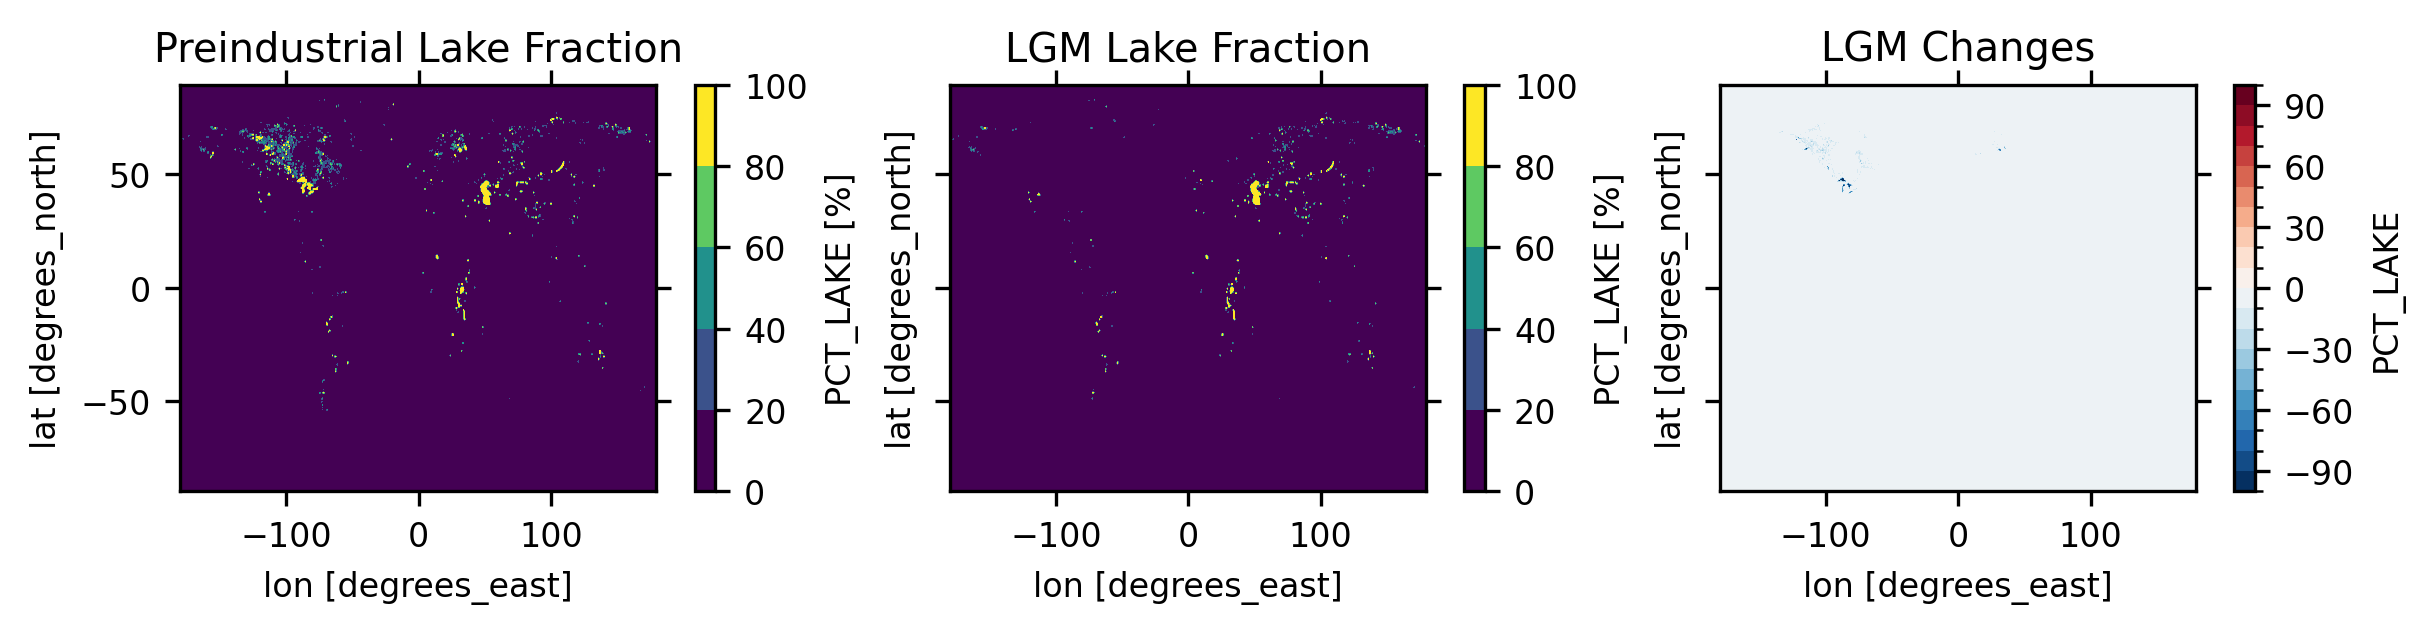

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_pctlak.PCT_LAKE.thin(10).plot.contourf(
    ax=axes[0])
axes[0].set_title('Preindustrial Lake Fraction')

ds_pctlak_lgm.PCT_LAKE.thin(10).plot.contourf(
    ax=axes[1])
axes[1].set_title('LGM Lake Fraction')

(ds_pctlak_lgm - ds_pctlak).PCT_LAKE.thin(10).plot.contourf(
    ax=axes[2], cmap='RdBu_r', levels=np.linspace(-100, 100, 21))
axes[2].set_title('LGM Changes')

---
## Step 3: Add PFTs over new LGM land points and remove PFTs underneath LGM ice sheets
- `LANDFRAC` in mksrf_fvegtyp is used as land fraction for the entire surfdata?
- `LANDMASK`, when mutiplied by 100, is the same as `PCT_NAT_PFT.sum('natpft')` to round-off error

In [27]:
pft_file = nml_dict['mksurfdata_input']['mksrf_fvegtyp']
ds_pft = xr.open_dataset(pft_file)
ds_pft_lgm = ds_pft.copy(deep=True)

fname = Path(Path(pft_file).name)
lgm_pft_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"
print(lgm_pft_file)

ds_pft

/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_histTRNOANTHRO_1.c240831_21ka.nc


<xarray.Dataset> Size: 2GB
Dimensions:                  (lat: 720, lon: 1440, natpft: 15, cft: 64)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 256B 15 16 17 18 19 ... 74 75 76 77 78
Dimensions without coordinates: lat, lon
Data variables: (12/28)
    EDGEN                    float32 4B ...
    EDGEE                    float32 4B ...
    EDGES                    float32 4B ...
    EDGEW                    float32 4B ...
    LAT                      (lat) float32 3kB ...
    LATIXY                   (lat, lon) float32 4MB ...
    ...                       ...
    HARVEST_SH1              (lat, lon) float64 8MB ...
    HARVEST_SH2              (lat, lon) float64 8MB ...
    HARVEST_SH3              (lat, lon) float64 8MB ...
    GRAZING                  (lat, lon) float64 8MB ...
    UNREPRESENTED_PFT_LULCC  (natpft, lat, lon) float64 124MB ...
    UNREPRESENTED_CFT_LULCC  (cft, lat, lon) float64 531MB ...
Attributes: (12/16)
    Conventions:        NCAR-CSM
    Author:             Peter Lawrence, lawrence@ucar.edu, NCAR, Terrestrial ...
    History_Log:        c240831
    Region:             /glade/campaign/cesm/development/lmwg/landuse_source_...
    ctsmLUHprimfDB:     /glade/campaign/cesm/development/lmwg/landuse_source_...
    CTSMSecdFDB:        /glade/campaign/cesm/development/lmwg/landuse_source_...
    ...                 ...
    CTSMC3PerDB:        /glade/campaign/cesm/development/lmwg/landuse_source_...
    CTSMC4PerDB:        /glade/campaign/cesm/development/lmwg/landuse_source_...
    CTSMC3NfxDB:        /glade/campaign/cesm/development/lmwg/landuse_source_...
    LUH2StatesDB:       /glade/campaign/cesm/development/lmwg/landuse_source_...
    LUH2ManagementDB:   /glade/campaign/cesm/development/lmwg/landuse_source_...
    LUH2TransitionsDB:  /glade/campaign/cesm/development/lmwg/landuse_source_...

### Update`LANDFRAC` and `LANDMASK` in the LGM pft file and make plots

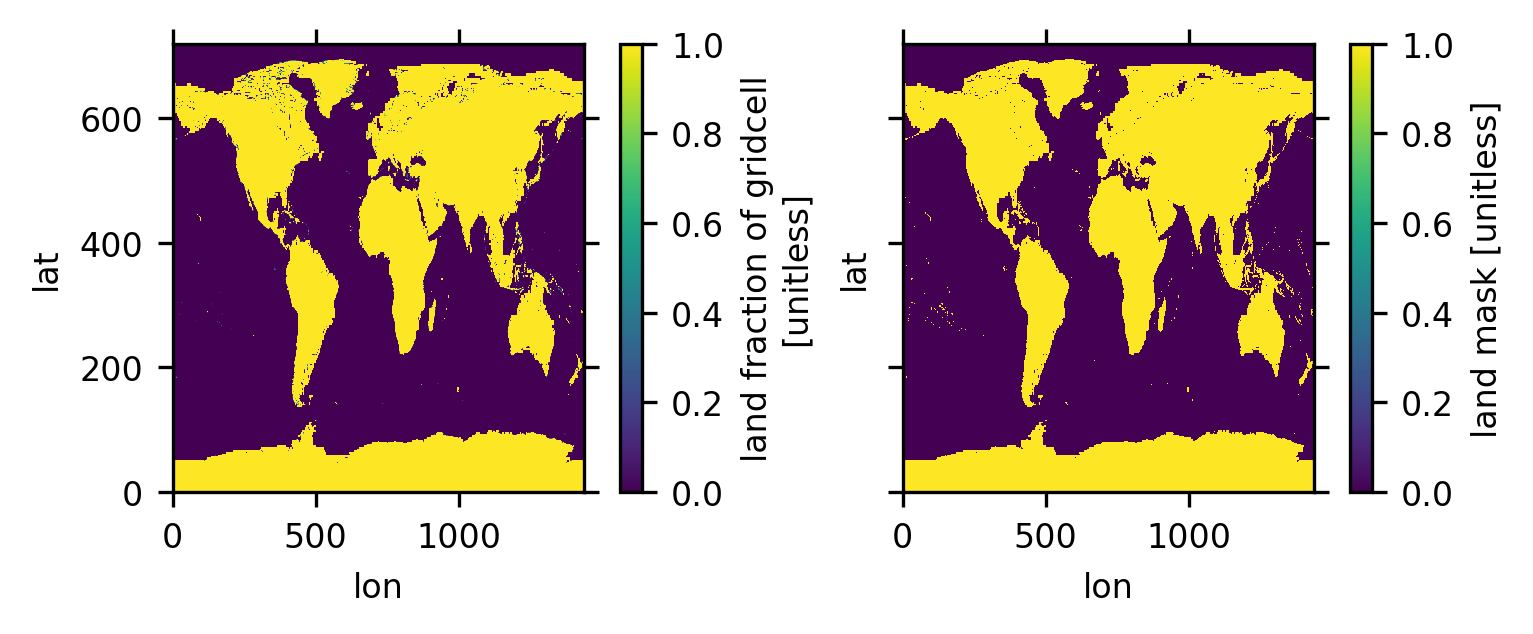

In [28]:
lgm_lndf_interp = lgm_lndf.interp(
    lat=ds_pft.LAT, lon=ds_pft.LON, method='linear')

ds_pft_lgm.LANDFRAC.data = xr.where(
    lgm_lndf_interp > ds_pft.LANDFRAC, lgm_lndf_interp, ds_pft.LANDFRAC)

ds_pft_lgm.LANDMASK.data = xr.where(ds_pft_lgm.LANDFRAC > 0, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
ds_pft_lgm.LANDFRAC.plot(ax=axes[0])
ds_pft_lgm.LANDMASK.plot(ax=axes[1])

### Add PFTs to `PCT_NATVEG` with nearest neighbor and then remove PFTs underneath ice sheets
- Scaling over coasts is needed? CTSM [1730](https://github.com/ESCOMP/CTSM/issues/1703) and [1716](https://github.com/ESCOMP/CTSM/issues/1716)
- If PCT_PFT, PCT_LAK, etc does not sum to 100% over the new LGM land, it will be scaled to 100% in mksurfdata_esmf?

In [29]:
dims_order = ds_pft_lgm.PCT_NATVEG.dims
pct_natveg_masked = xr.where(
    ds_pft.LANDMASK > 0, ds_pft_lgm.PCT_NATVEG / ds_pft.LANDFRAC / 100, np.nan).transpose(*dims_order)

ds_pft_lgm.PCT_NATVEG.data = fill_na(pct_natveg_masked, 'lon', 'lat')

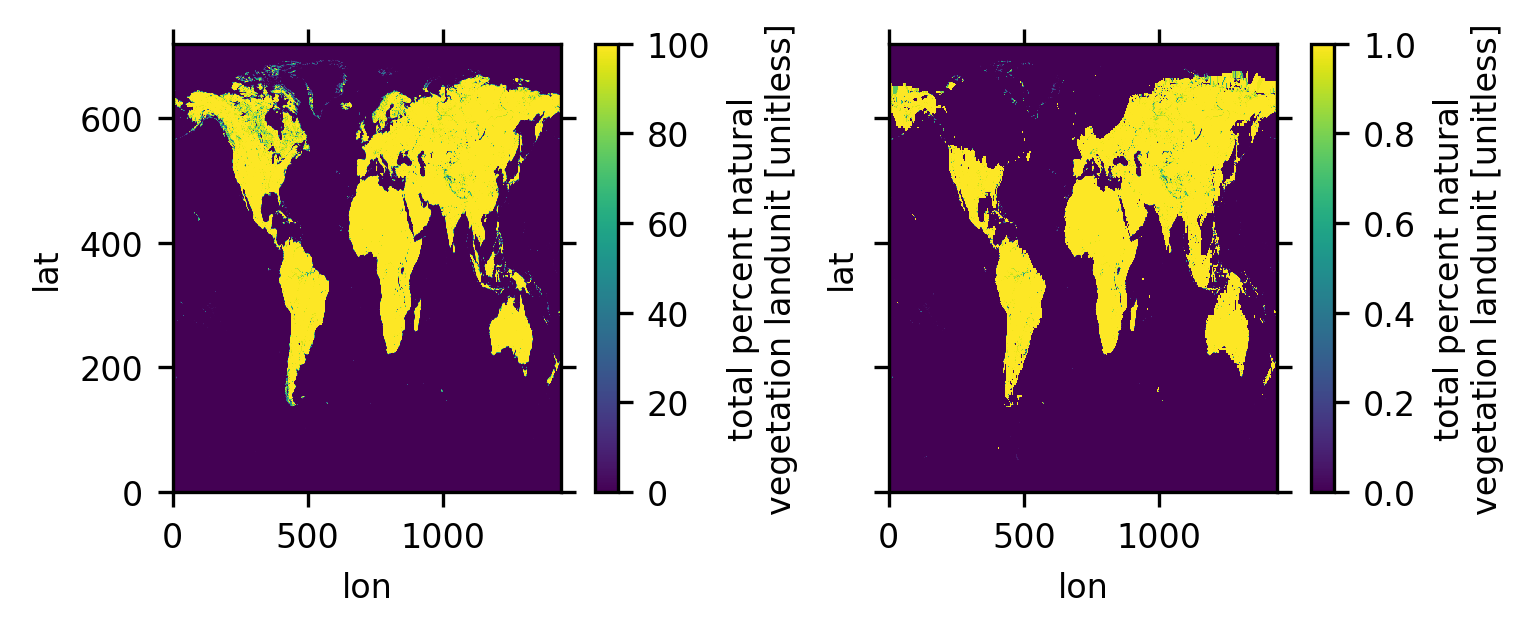

In [30]:
glc_ano_i6g_int = glc_ano_i6g.interp(
    lat=ds_pft_lgm.LAT, lon=ds_pft_lgm.LON, method='linear')

ds_pft_lgm.PCT_NATVEG.data = xr.where(
    glc_ano_i6g_int.data > 50, 0, ds_pft_lgm.PCT_NATVEG)*ds_pft_lgm.LANDFRAC

fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
ds_pft.PCT_NATVEG.plot(ax=axes[0])
ds_pft_lgm.PCT_NATVEG.plot(ax=axes[1])

### Add PFTs to `PCT_NAT_PFT` with nearest neighbor

In [31]:
dims_order = ds_pft_lgm.PCT_NAT_PFT.dims
pct_nat_pft_masked = xr.where(
    ds_pft.LANDMASK > 0, ds_pft_lgm.PCT_NAT_PFT, np.nan).transpose(*dims_order)

ds_pft_lgm.PCT_NAT_PFT.data = fill_na(
    pct_nat_pft_masked, 'lon', 'lat') * ds_pft_lgm.LANDMASK

### Save the LGM PFT file and update the namelist

In [32]:
ds_pft_lgm.to_netcdf(lgm_pft_file)
subprocess.run(['ncks', "-hO5", lgm_pft_file, lgm_pft_file])

for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fvegtyp'] = lgm_pft_file
    print(cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fvegtyp'])

/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_histTRNOANTHRO_1.c240831_21ka.nc
/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_histTRNOANTHRO_1.c240831_21ka.nc


### Make plots to check results

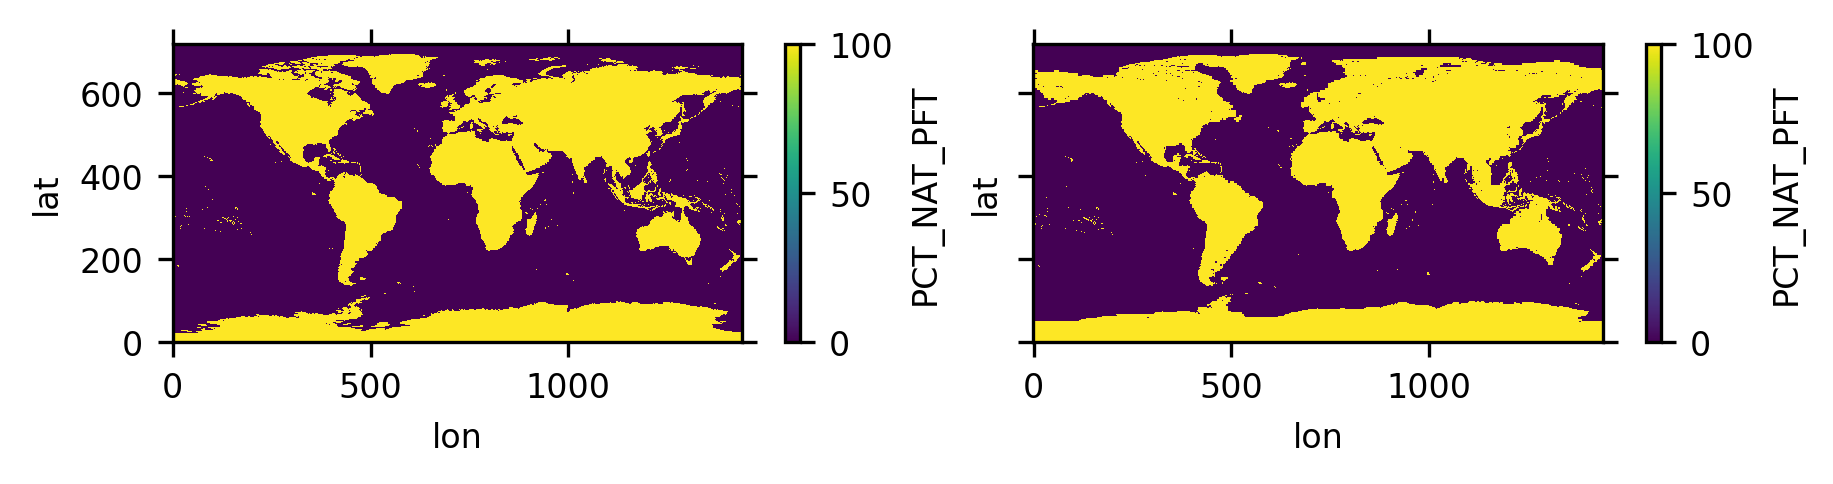

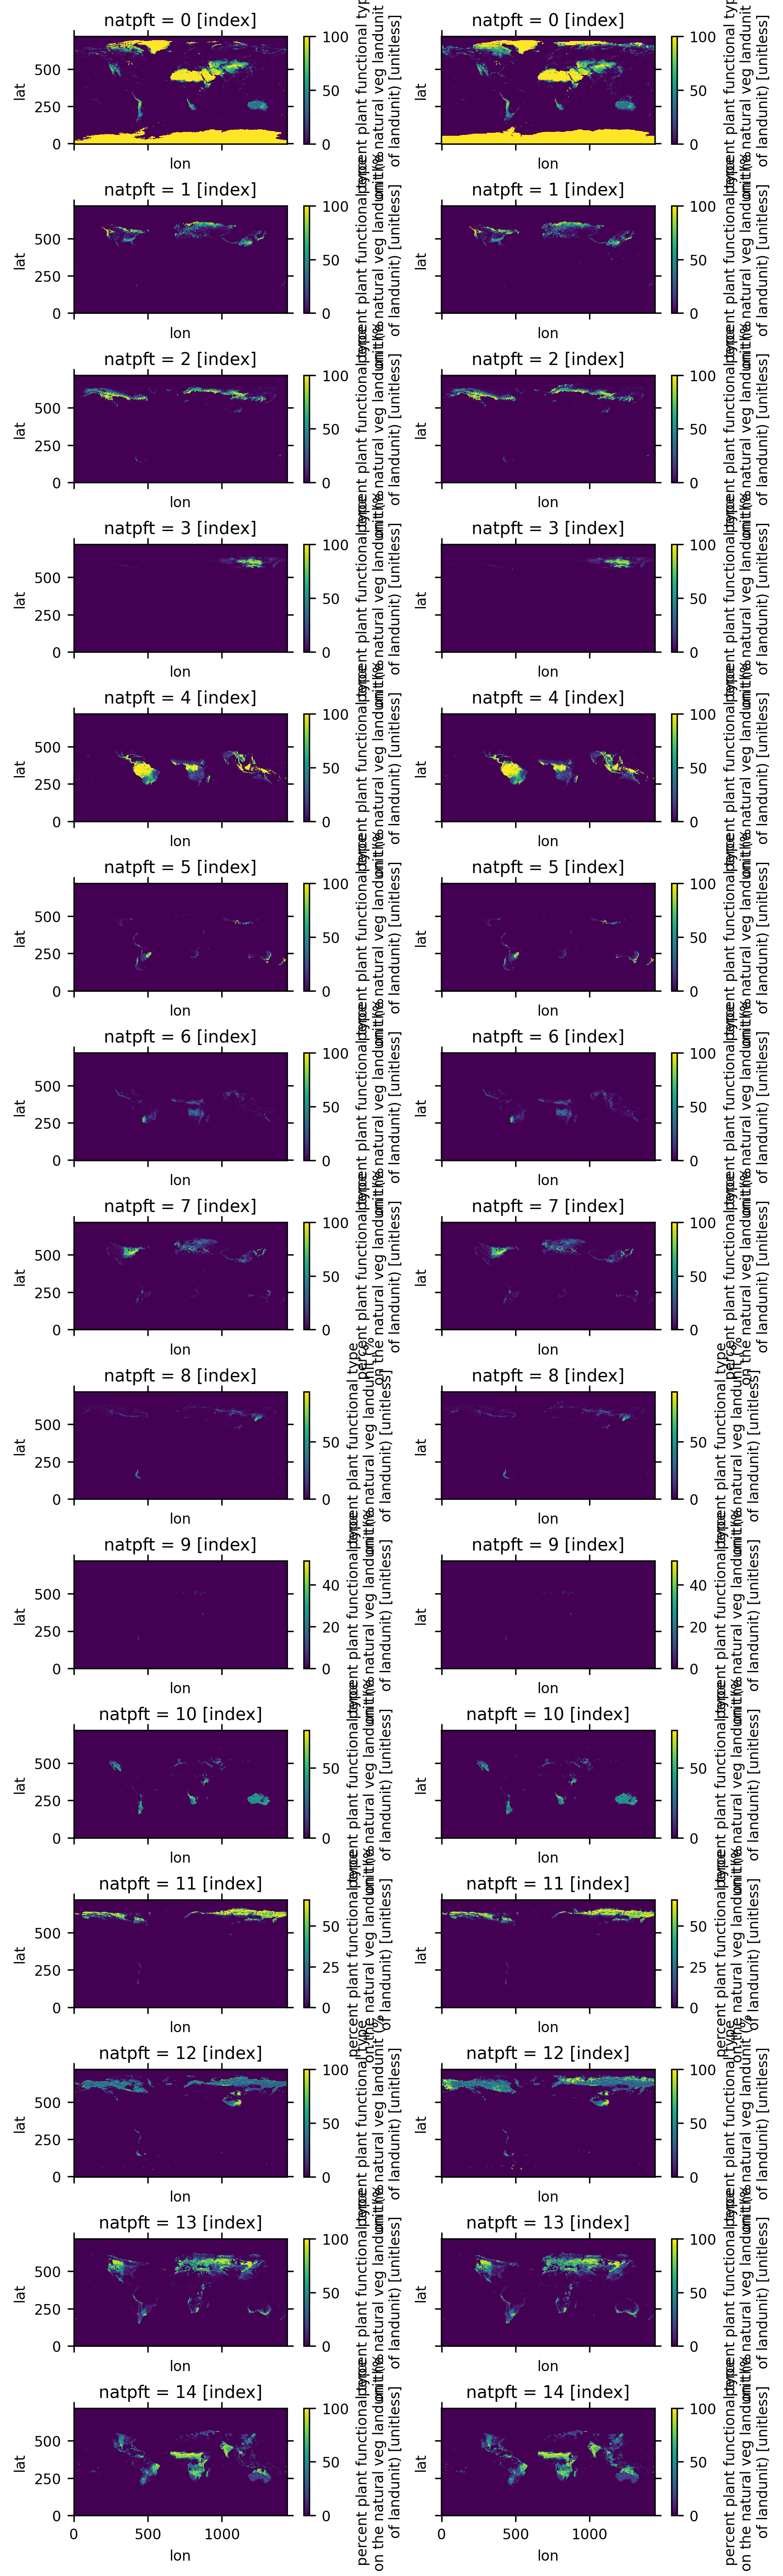

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(6, 1.5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_pft.PCT_NAT_PFT.sum('natpft').plot(ax=axes[0])
ds_pft_lgm.PCT_NAT_PFT.sum('natpft').plot(ax=axes[1])

fig, axes = plt.subplots(15, 2, figsize=(6, 20),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i_pft in ds_pft_lgm.natpft.values:
    ds_pft.PCT_NAT_PFT.isel(natpft=i_pft).plot(ax=axes[i_pft, 0])
    ds_pft_lgm.PCT_NAT_PFT.isel(natpft=i_pft).plot(ax=axes[i_pft, 1])

---
## Step 4: Create the LGM mksrf_fglacier
- Somehow, PCT_GLACIER, PCT_GLC_ICESHEET.sum('z'), and PCT_GLC_GIC.sum('z') in the preindustrial raw file could be slightly greater than 100%, likely due to interpolation. I am going to ignore this inconsistency.

In [34]:
glc_file = nml_dict['mksurfdata_input']['mksrf_fglacier']
ds_glc = xr.open_dataset(glc_file)

ds_glc_lgm = ds_glc.copy(deep=True)

fname = Path(Path(glc_file).name)
lgm_glc_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"
print(lgm_glc_file)

ds_glc

/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_glacier_3x3min_simyr2000.c20210708_21ka.nc


<xarray.Dataset> Size: 15GB
Dimensions:           (lat: 3600, lon: 7200, z: 71, z_edge: 72)
Dimensions without coordinates: lat, lon, z, z_edge
Data variables:
    PCT_GLACIER       (lat, lon) float32 104MB ...
    LANDMASK          (lat, lon) float32 104MB ...
    TOPO              (lat, lon) float32 104MB ...
    BIN_CENTERS       (z) float32 284B ...
    BIN_EDGES         (z_edge) float32 288B ...
    LAT               (lat) float32 14kB ...
    LON               (lon) float32 29kB ...
    LATIXY            (lat, lon) float32 104MB ...
    LONGXY            (lat, lon) float32 104MB ...
    PCT_GLC_GIC       (z, lat, lon) float32 7GB ...
    PCT_GLC_ICESHEET  (z, lat, lon) float32 7GB ...
Attributes:
    creation_date:  Thu Jul  8 18:53:28 MDT 2021
    title:          CTSM percent glacier dataset and associated topography ve...
    summary:        (See description.)
    creator:        Rene Wijngaard and Adam Herrington
    contact:        CISM Subboard at https://bb.cgd.ucar.edu
    data_script:    https://docs.google.com/document/d/1HZxoyzvcnIpt6q6OuO_L6...
    description:    The updated glacier dataset (version 2) uses glacier outl...

### Make plots of variables

0.0
0.0
100.00001525878906
100.00001525878906
100.00001525878906


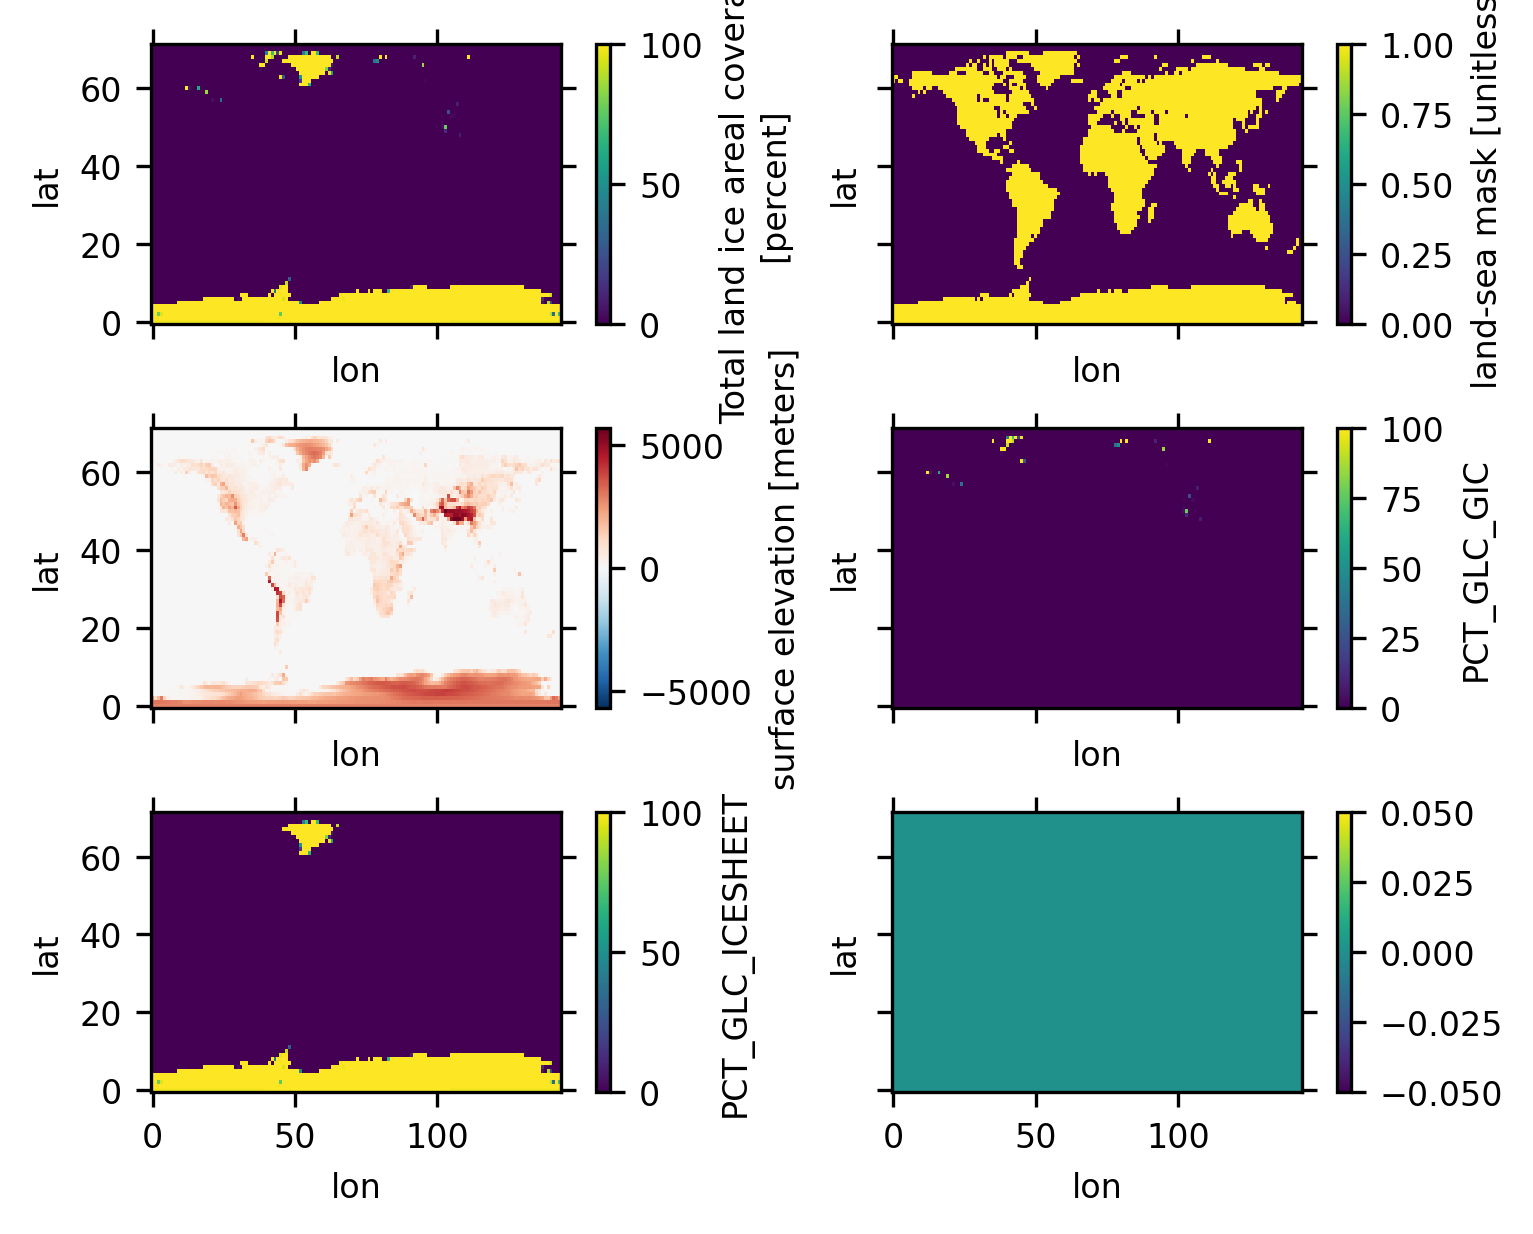

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(5, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for vname, ax in zip(
    ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET'],
    axes,
):
    var = ds_glc[vname]
    if vname == 'PCT_GLC_GIC' or vname =='PCT_GLC_ICESHEET':
        var = ds_glc[vname].sum('z')
    var.thin(50).plot(ax=ax)

var = ds_glc['PCT_GLACIER'] - (ds_glc['PCT_GLC_GIC'] + ds_glc['PCT_GLC_ICESHEET']).sum('z')
var.thin(50).plot(ax=axes[5])
print(var.max().values)
print(var.min().values)

print(ds_glc.PCT_GLACIER.max().values)
print(ds_glc.PCT_GLC_ICESHEET.sum('z').max().values)
print(ds_glc.PCT_GLC_GIC.sum('z').max().values)

### Take a look at Greenland Summit

In [36]:
idx_lat = 3250
idx_lon = 2800

idx_lat = 3250
idx_lon = 2600

idx_lat = 3250
idx_lon = 2550

ds = ds_glc

print(f"Examine point: lat = {ds.LAT.isel(lat=idx_lat).values:5.2f}, lon = {ds.LON.isel(lon=idx_lon).values:5.2f}")

for vname in ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
    print(f"{vname}: {ds[vname].isel(lat=idx_lat, lon=idx_lon).values}")

bins_e = ds.BIN_EDGES.values
bins_c = ds.BIN_CENTERS.values
print(f"BIN_EDGES: {bins_e}")
print(f"BIN_CENTERS: {bins_c}")
print(f"bin spacing: {np.diff(bins_c)}")
bin_idx = np.digitize(ds.TOPO.isel(lat=idx_lat, lon=idx_lon), bins_e)
print(bin_idx)

print(bins_c[bin_idx-1])

print(np.nonzero(ds.PCT_GLC_ICESHEET.isel(lat=idx_lat, lon=idx_lon).values)[0])

Examine point: lat = 72.53, lon = -52.47
PCT_GLACIER: 100.0
LANDMASK: 1.0
TOPO: 1597.8160400390625
PCT_GLC_GIC: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PCT_GLC_ICESHEET: [ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.       52.933975 47.066025  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0

### Step 4.1 Create the LGM LANDMASK and TOPO

In [37]:
lgm_lndf_interp = lgm_lndf.interp(
    lat=ds_glc.LAT, lon=ds_glc.LON, method='linear')

ds_glc_lgm.LANDMASK.data = xr.where(
    (ds_glc.LANDMASK < 1) & (lgm_lndf_interp.values > 0.5), 1, ds_glc.LANDMASK)

In [38]:
glc_ano_i6g_int = topo_ano_i6g.interp(
    lat=ds_glc.LAT, lon=ds_glc.LON, method='linear')

ds_glc_lgm.TOPO.data = ds_glc.TOPO + glc_ano_i6g_int

print(f"Preindustrial topo height: max = {ds_glc.TOPO.max().values:5.2f}, min = {ds_glc.TOPO.min().values:5.2f}")
print(f"New LGM topo height: max = {ds_glc_lgm.TOPO.max().values:5.2f}, min = {ds_glc_lgm.TOPO.min().values:5.2f}")

Preindustrial topo height: max = 7881.95, min = -412.00
New LGM topo height: max = 7971.24, min = -319.65


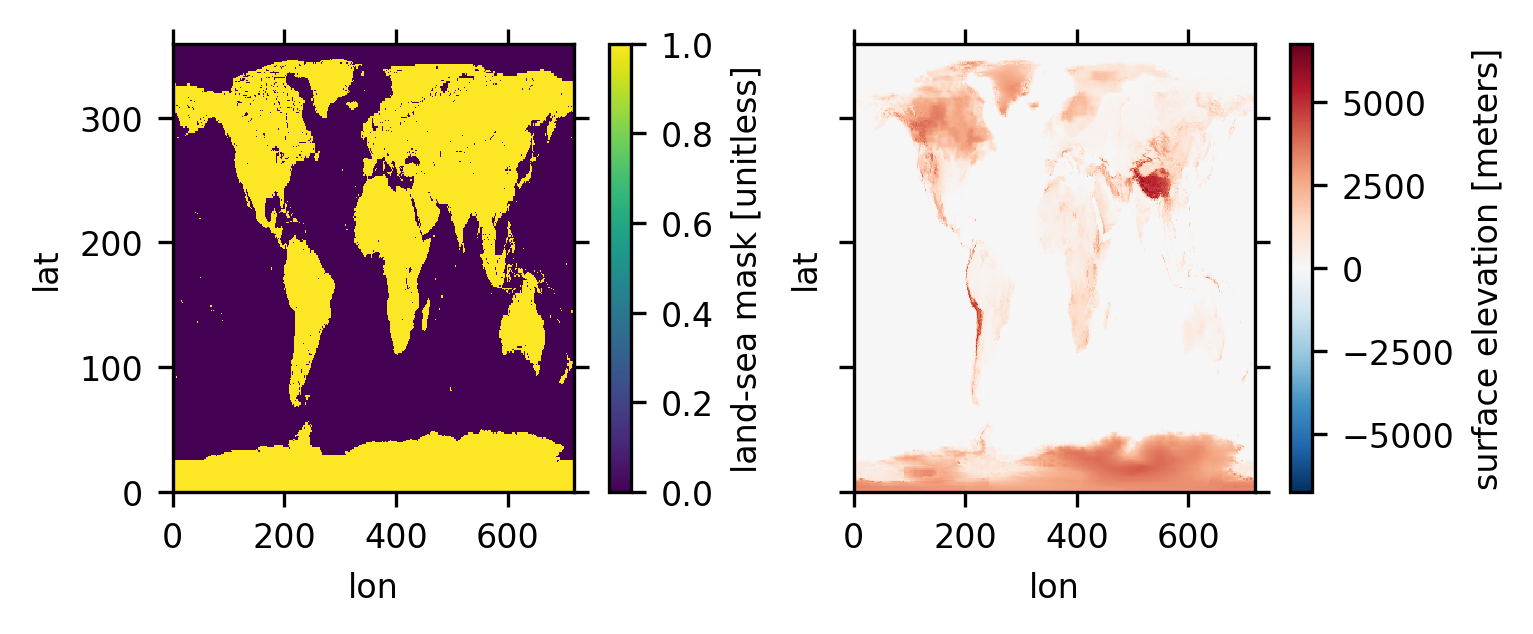

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_glc_lgm.LANDMASK.thin(10).plot.pcolormesh(ax=axes[0])
ds_glc_lgm.TOPO.thin(10).plot.pcolormesh(ax=axes[1])

### Step 4.2 Create PCT_GLC_GIC and PCT_GLC_ICESHEET
- For simplicity, I did not adjust non-LGM-glaciated regions. For example, glaciers (`PCT_GLC_GIC`) over the Himalaya are not changes in coverage and elevation class.
  - It is imperfect to ingore the sea level and GIA effects (i.e. the Himalayan glaciers should have been in higher elevation class) but I don't think it impacts simulation results much.
  - It should be more accurate if we directly work with the orignal land ice coverage data in 30arcsec.

LGM ICE-G ice sheet pct: max = 100.0, min = 0.0


<xarray.DataArray 'sftgif' (lat: 3600, lon: 7200)> Size: 207MB
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lat      (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon      (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    long_name:  Ice area fraction. Time=21 Ka
    units:      %
    time:        21.00 KBP

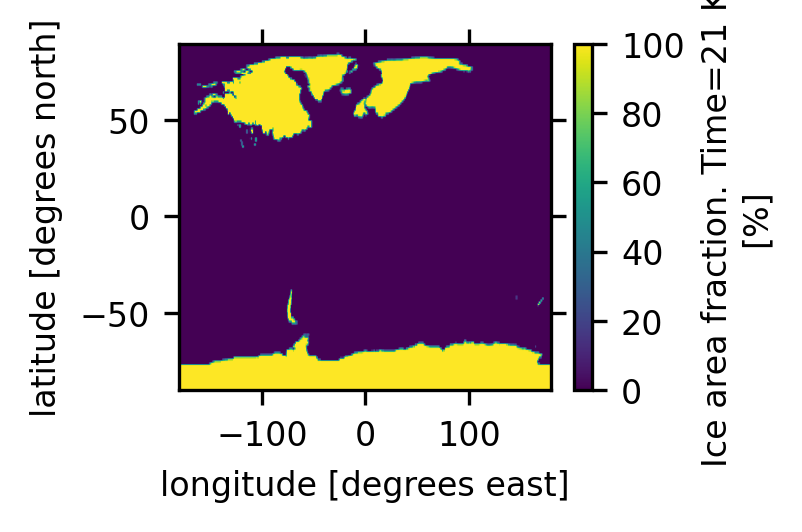

In [40]:
glc_ano_i6g_int = glc_lgm_i6g.interp(
    lat=ds_glc.LAT, lon=ds_glc.LON, method='linear')
glc_ano_i6g_int.thin(10).plot(size=1.5)

print(f"LGM ICE-G ice sheet pct: max = {glc_ano_i6g_int.max().values}, min = {glc_ano_i6g_int.min().values}")
glc_ano_i6g_int

#### Use np.digitize to bin the LGM TOPO into elevation classes

In [41]:
lgm_elevation_class = xr.apply_ufunc(np.digitize, ds_glc_lgm.TOPO, bins_e) - 1
lgm_elevation_class = xr.where(lgm_elevation_class < 0, 0, lgm_elevation_class)
lgm_elevation_class = xr.where(lgm_elevation_class > 70, 00, lgm_elevation_class)

lgm_elevation_class
print(f"lgm_elevation_class: max = {lgm_elevation_class.max().values:5.2f}, min = {lgm_elevation_class.min().values:5.2f}")

lgm_elevation_class: max = 70.00, min =  0.00


In [42]:
# Explore np.digitize
print(bins_e)
print(len(bins_e))
print(np.digitize(50, bins_e))
print(np.digitize(100050, bins_e))

[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000. 10000.]
72
1
72


#### Assign ice sheet coverage according to the elevation class

In [43]:
lgm_pct_icesheet = ds_glc_lgm.PCT_GLC_ICESHEET * 0

lgm_pct_icesheet.loc[dict(z=lgm_elevation_class,
                          lat=ds_glc_lgm.lat,
                          lon=ds_glc_lgm.lon)] = glc_ano_i6g_int

#### Only update the LGM glacier coverage over ICE-6G ice region

In [44]:
dims_order = ds_glc_lgm.PCT_GLC_ICESHEET.dims

# Set the LGM ice sheet coverage as that from ICE-6G
ds_glc_lgm.PCT_GLC_ICESHEET.data = xr.where(
    glc_ano_i6g_int > 0, lgm_pct_icesheet, ds_glc_lgm.PCT_GLC_ICESHEET).transpose(*dims_order)

# Set the LGM glacier coverage as zero if ICE-6G ice exists
ds_glc_lgm.PCT_GLC_GIC.data = xr.where(
    glc_ano_i6g_int > 0, 0, ds_glc_lgm.PCT_GLC_GIC).transpose(*dims_order)

# Set PCT_GLACIER and the sum of glaciers and ice sheets over the elevation classes
ds_glc_lgm.PCT_GLACIER.data = (ds_glc_lgm.PCT_GLC_GIC + ds_glc_lgm.PCT_GLC_ICESHEET).sum('z')

# Again, I am going to allow the existence of data >100%, as they are small and inherented from the preindustrial file
print(ds_glc_lgm.PCT_GLACIER.max().values)
print(ds_glc_lgm.PCT_GLC_ICESHEET.sum('z').max().values)
print(ds_glc_lgm.PCT_GLC_GIC.sum('z').max().values)

100.00000762939453
100.0
100.00000762939453


#### Make plots to check results

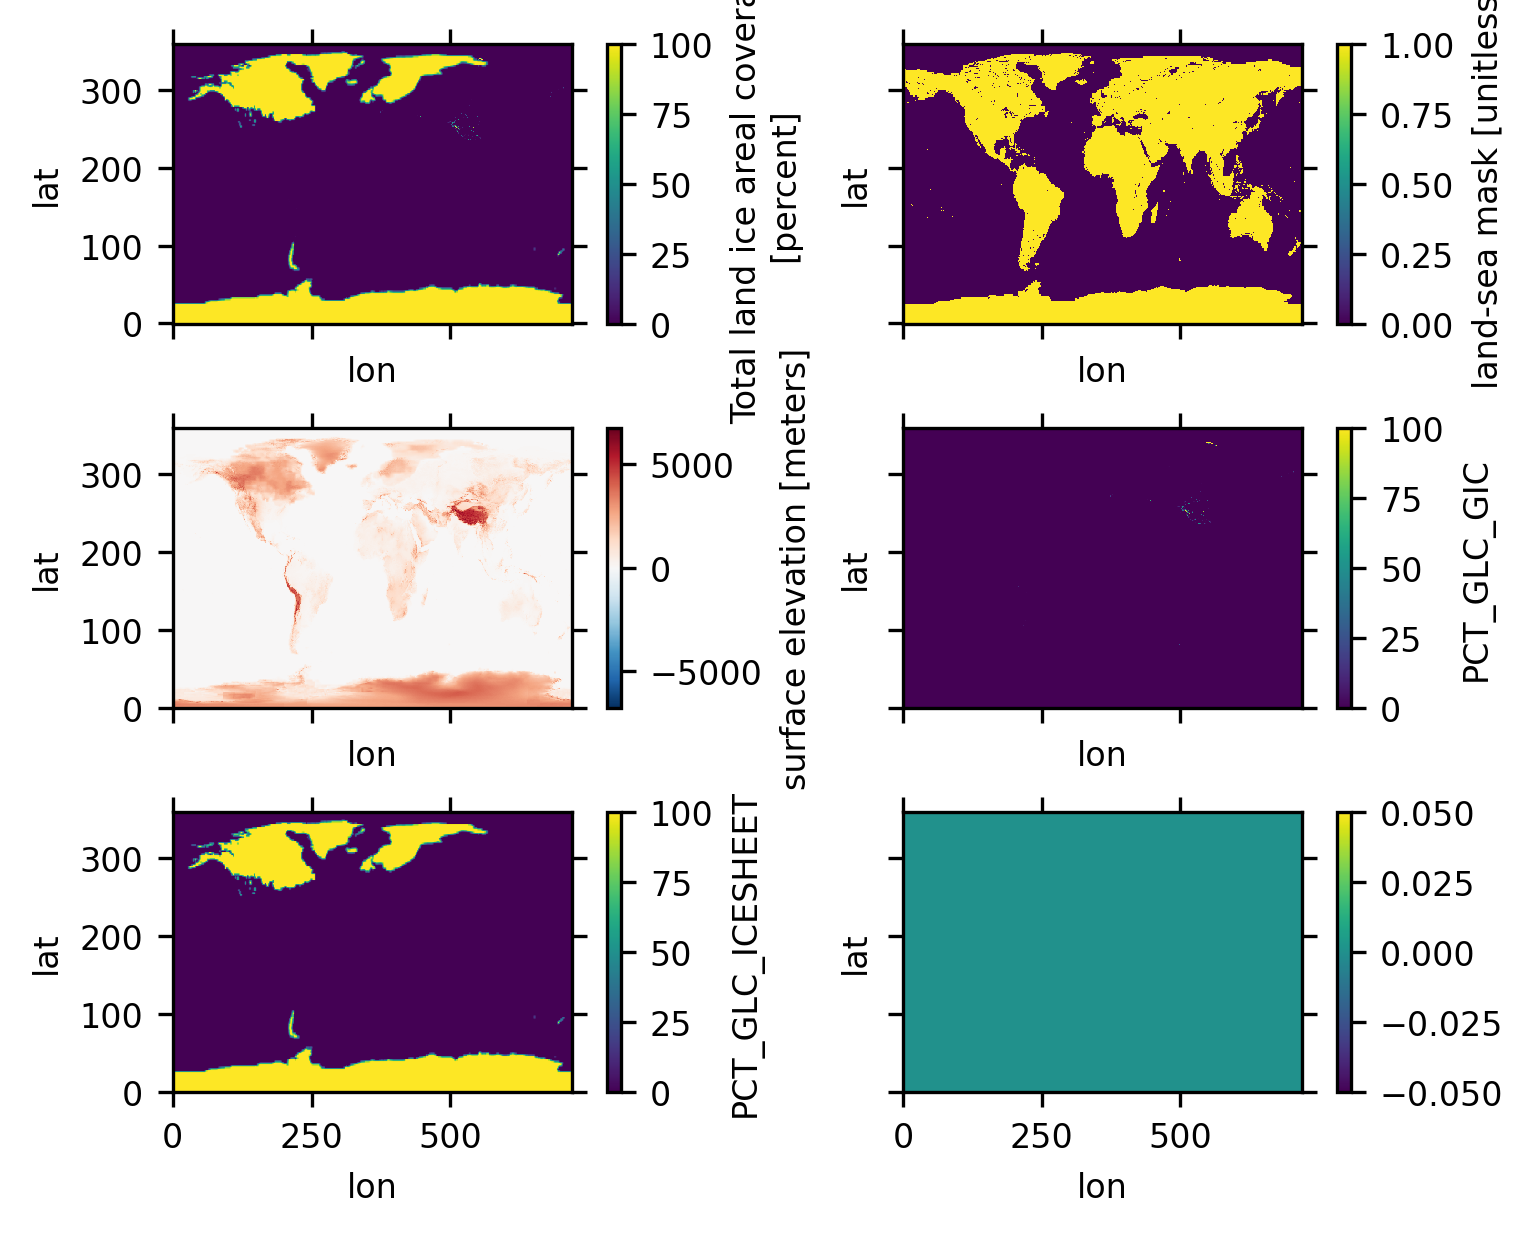

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(5, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for vname, ax in zip(
    ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET'],
    axes,
):
    var = ds_glc_lgm[vname]
    if vname == 'PCT_GLC_GIC' or vname == 'PCT_GLC_ICESHEET':
        var = ds_glc_lgm[vname].sum('z')
    var.thin(10).plot(ax=ax)

var = ds_glc_lgm['PCT_GLACIER'] - (ds_glc_lgm['PCT_GLC_GIC'] + ds_glc_lgm['PCT_GLC_ICESHEET']).sum('z')
var.thin(10).plot(ax=axes[5])

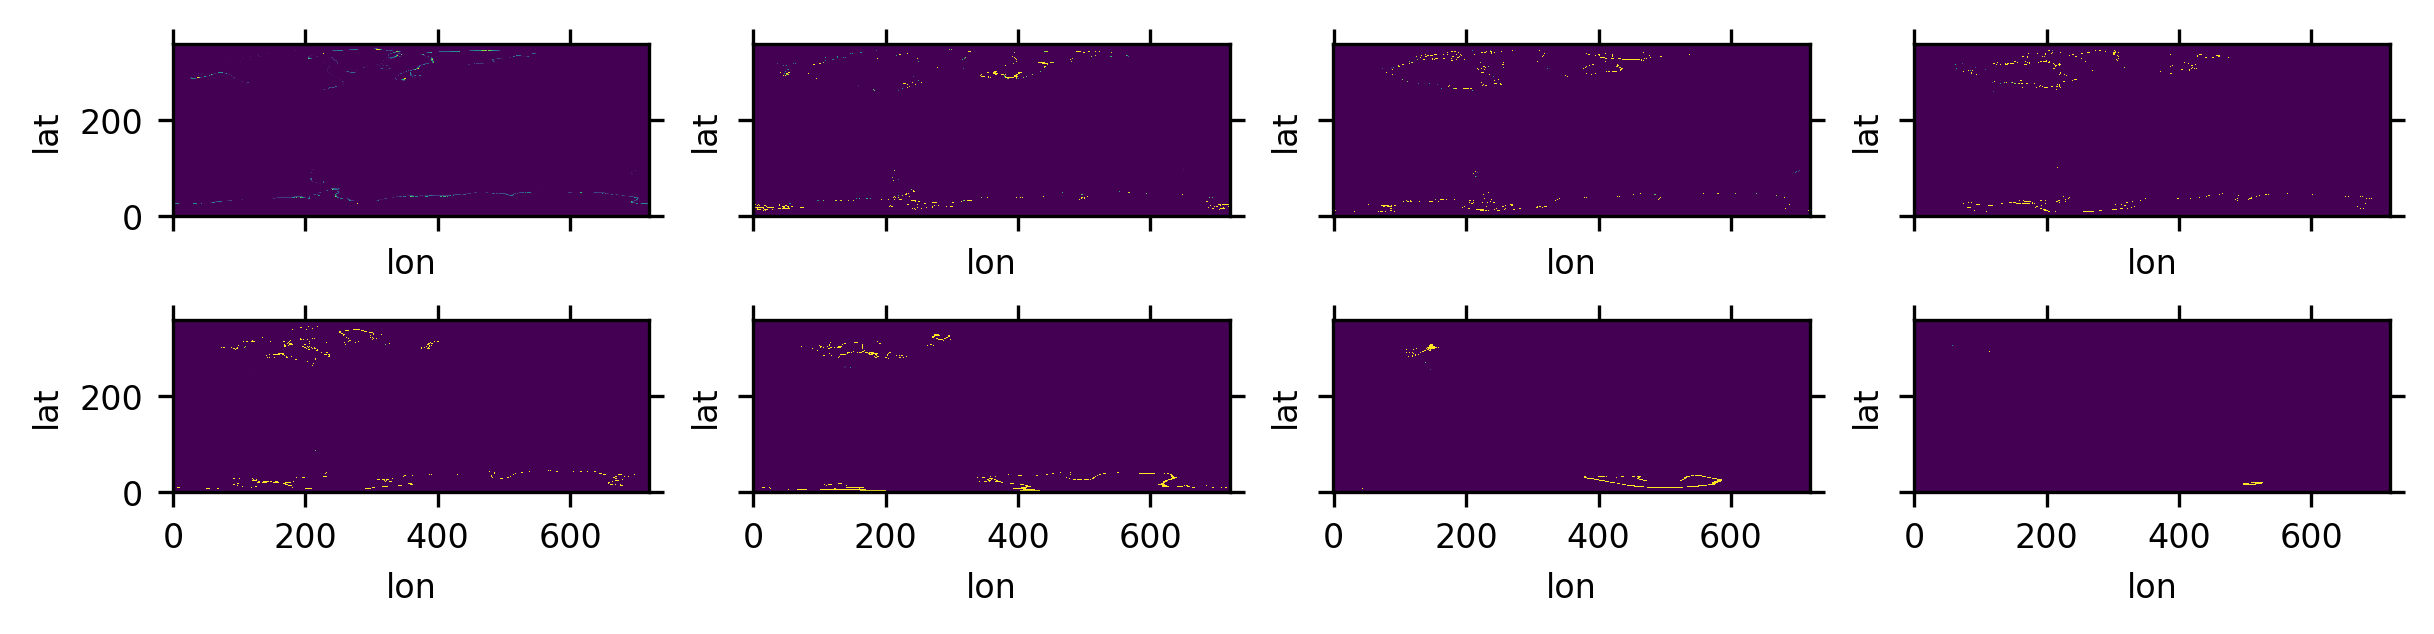

In [46]:
fig, axes = plt.subplots(2, 4, figsize=(8, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for i_elev, ax in zip(np.linspace(0, 40, 8).astype(int), axes):

    ds_glc_lgm.PCT_GLC_ICESHEET.isel(z=i_elev).thin(10).plot(
        ax=ax, add_colorbar=False)

### Take a look at a grid point over the Laurentide Ice Sheet

In [47]:
idx_lat = 3000
idx_lon = 1500

ds = ds_glc_lgm

print(f"Examine point: lat = {ds.LAT.isel(lat=idx_lat).values:5.2f}, lon = {ds.LON.isel(lon=idx_lon).values:5.2f}")

for vname in ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
    print(f"{vname}: {ds[vname].isel(lat=idx_lat, lon=idx_lon).values}")

bins_e = ds.BIN_EDGES.values
bins_c = ds.BIN_CENTERS.values
print(f"BIN_EDGES: {bins_e}")
print(f"BIN_CENTERS: {bins_c}")
print(f"bin spacing: {np.diff(bins_c)}")
bin_idx = np.digitize(ds.TOPO.isel(lat=idx_lat, lon=idx_lon), bins_e)
print(bin_idx)

print(bins_c[bin_idx-1])

print(np.nonzero(ds.PCT_GLC_ICESHEET.isel(lat=idx_lat, lon=idx_lon).values)[0])

Examine point: lat = 60.03, lon = -104.97
PCT_GLACIER: 100.0
LANDMASK: 1.0
TOPO: 3498.0449423463124
PCT_GLC_GIC: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PCT_GLC_ICESHEET: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
BIN_EDGES: [    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3

### Save the LGM glacier file and update the namelist

In [48]:
%%time

ds_glc_lgm.to_netcdf(lgm_glc_file)
subprocess.run(['ncks', "-hO5", lgm_glc_file, lgm_glc_file])

for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacier'] = lgm_glc_file
    print(cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacier'])

/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_glacier_3x3min_simyr2000.c20210708_21ka.nc
/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_glacier_3x3min_simyr2000.c20210708_21ka.nc
CPU times: user 5.78 s, sys: 19.5 s, total: 25.3 s
Wall time: 1min 24s


### Update the LGM glacier region file

In [49]:
for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacierregion'] = '/glade/campaign/cesm/development/palwg/raw_boundary_data/GLACIER_REGION.nc'
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacierregion_mesh'] = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.9x1.25_nomask_cdf5_c200129.nc'

---
## Step 5: Write the final namelist file and run mksurfdata
⚠️**CHECK THE NAMELIST FILE CAREFULLY BEFORE RUNNING.**
- You have multiple options to run `mksurfdata`:
  - Use the `qcmd` call below to submit job on Derecho
  - Write and run a separate job script on Derecho (see example: `/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksurfdata_jobscript_single.sh`)

### Write namelist files

In [50]:
for grid, cfg in grid_configs.items():
    print(f"\n{grid}: {cfg['lgm_nml']}\n")

    lgm_nml_dict = cfg['lgm_nml_dict']
    f90nml.write(lgm_nml_dict, cfg['lgm_nml'], force=True)

    for key in lgm_nml_dict['mksurfdata_input'].keys():
        print(f"{key}: {lgm_nml_dict['mksurfdata_input'][key]}")


ne30np4.pg3: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.namelist

mksrf_fgrid_mesh: /glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc
mksrf_fgrid_mesh_nx: 48600
mksrf_fgrid_mesh_ny: 1
mksrf_flai: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_pftlai_CLIM.c240709_21ka_nnfilled.nc
mksrf_flai_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoicol: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_ctsm53_soilcolor_CLIM.c240709_21ka_nnfilled.nc
mksrf_fsoicol_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoitex: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_soil_mapunits_5x5min_WISE.c220330_21ka_nnfilled.nc
mksrf_fsoitex_lookup: /glade/campaign/cesm/ce

### Submit job on Derecho with qcmd

In [ ]:
# Build up the commands for all grids
job_commands = []
for grid, cfg in grid_configs.items():
    job_commands.append(
        f"{mksurfdata_exe} < {cfg['lgm_nml']} > log 2>&1"
    )

# Join commands for serial execution
all_cmds = " && ".join(job_commands)

cmd = [
    "qcmd",
    "-N", "mksurfdata",
    "-A", "P93300324",
    "-q", "main",
    "-l", "select=4:ncpus=128:mpiprocs=128",
    "-l", "walltime=06:00:00",
    "-l", "JOB_PRIORITY=premium",
    "--",
    f"bash -l -c 'module load ncarenv/24.12 intel/2024.2.1 libfabric && {all_cmds}'"
]

print("Submitting combined mksurfdata job:\n ", " ".join(cmd))
subprocess.run(cmd, check=True)


Submitting combined mksurfdata job:
  qcmd -N mksurfdata -A P93300324 -q main -l select=4:ncpus=128:mpiprocs=128 -l walltime=06:00:00 -l JOB_PRIORITY=premium -- bash -l -c 'module load ncarenv/24.12 intel/2024.2.1 libfabric && /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/tool_bld/mksurfdata < /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.namelist > /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.log 2>&1 && /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/tool_bld/mksurfdata < /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne16np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.namelist > /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne16np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250924.log 2>&1'
Waiting on job launch; 3220236.desched1 with qsub arguments:
    qsub  -l select=4:ncpus=128:

---
## Step 6: Update the SLOPE and STDELEV variables in the surfdata
- We skipped the mksrf_ftopostats file because I don't know how to modify it.
- I am directly updating the variables in the surface data using nearest neighbor.
- SLOPE is used in Surface Water Storage and ELEVATION is used in Snow Covered Area Fraction.
- I think it is also fine to skip this step.

In [62]:
for grid, cfg in grid_configs.items():

    fsurdat_out_topostats = cfg['fsurdat_out_topostats']

    ds_lgm_surfdata = xr.open_dataset(cfg['fsurdat_out'])

    # Use this file to get the land fraction, LANDFRAC_MKSURFDATA
    ds_pre_surfdata = xr.open_dataset(cfg["fsurdat_pre"])

    for var in ["STD_ELEV", "SLOPE"]:
        # Preserve original dimension order
        dims_order = ds_lgm_surfdata[var].dims

        # Mask using pre-industrial land fraction
        masked = xr.where(
            ds_pre_surfdata.LANDFRAC_MKSURFDATA > 0,
            ds_lgm_surfdata[var],
            np.nan
        ).transpose(*dims_order)

        # Fill missing values (nearest neighbor)
        # There may be a better method to find nearest neighbor on the CAM-SE grid.
        # For now, I am using this.
        filled = fill_na(masked, 'gridcell', 'gridcell')

        # Apply mask to final data
        ds_lgm_surfdata[var].data = filled * xr.where(
            ds_lgm_surfdata.LANDFRAC_MKSURFDATA > 0,
            1,
            0
        )

    # Save updated dataset and compress
    ds_lgm_surfdata.to_netcdf(cfg['fsurdat_out_topostats'])
    subprocess.run(
        ['ncks', "-hO5",
         cfg['fsurdat_out_topostats'],
         cfg['fsurdat_out_topostats']]
    )